In [2]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
mpl.rcParams['figure.dpi'] = 400

c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
df = pd.read_csv('../Data/df_clean_2.csv')

In [4]:
df.columns.to_list()

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'EDUCATION_CAT']

For ethical reasons, gender will not be used.

Further, as per our earlier data exploration, PAY_2 through PAY_6 contain faulty data and should also be ignored.

In [5]:
features_response = df.columns.tolist()

In [6]:
features_response

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'EDUCATION_CAT']

In [7]:
features_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_CAT']

In [8]:
features = [col for col in features_response if col not in features_to_remove]

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot:>

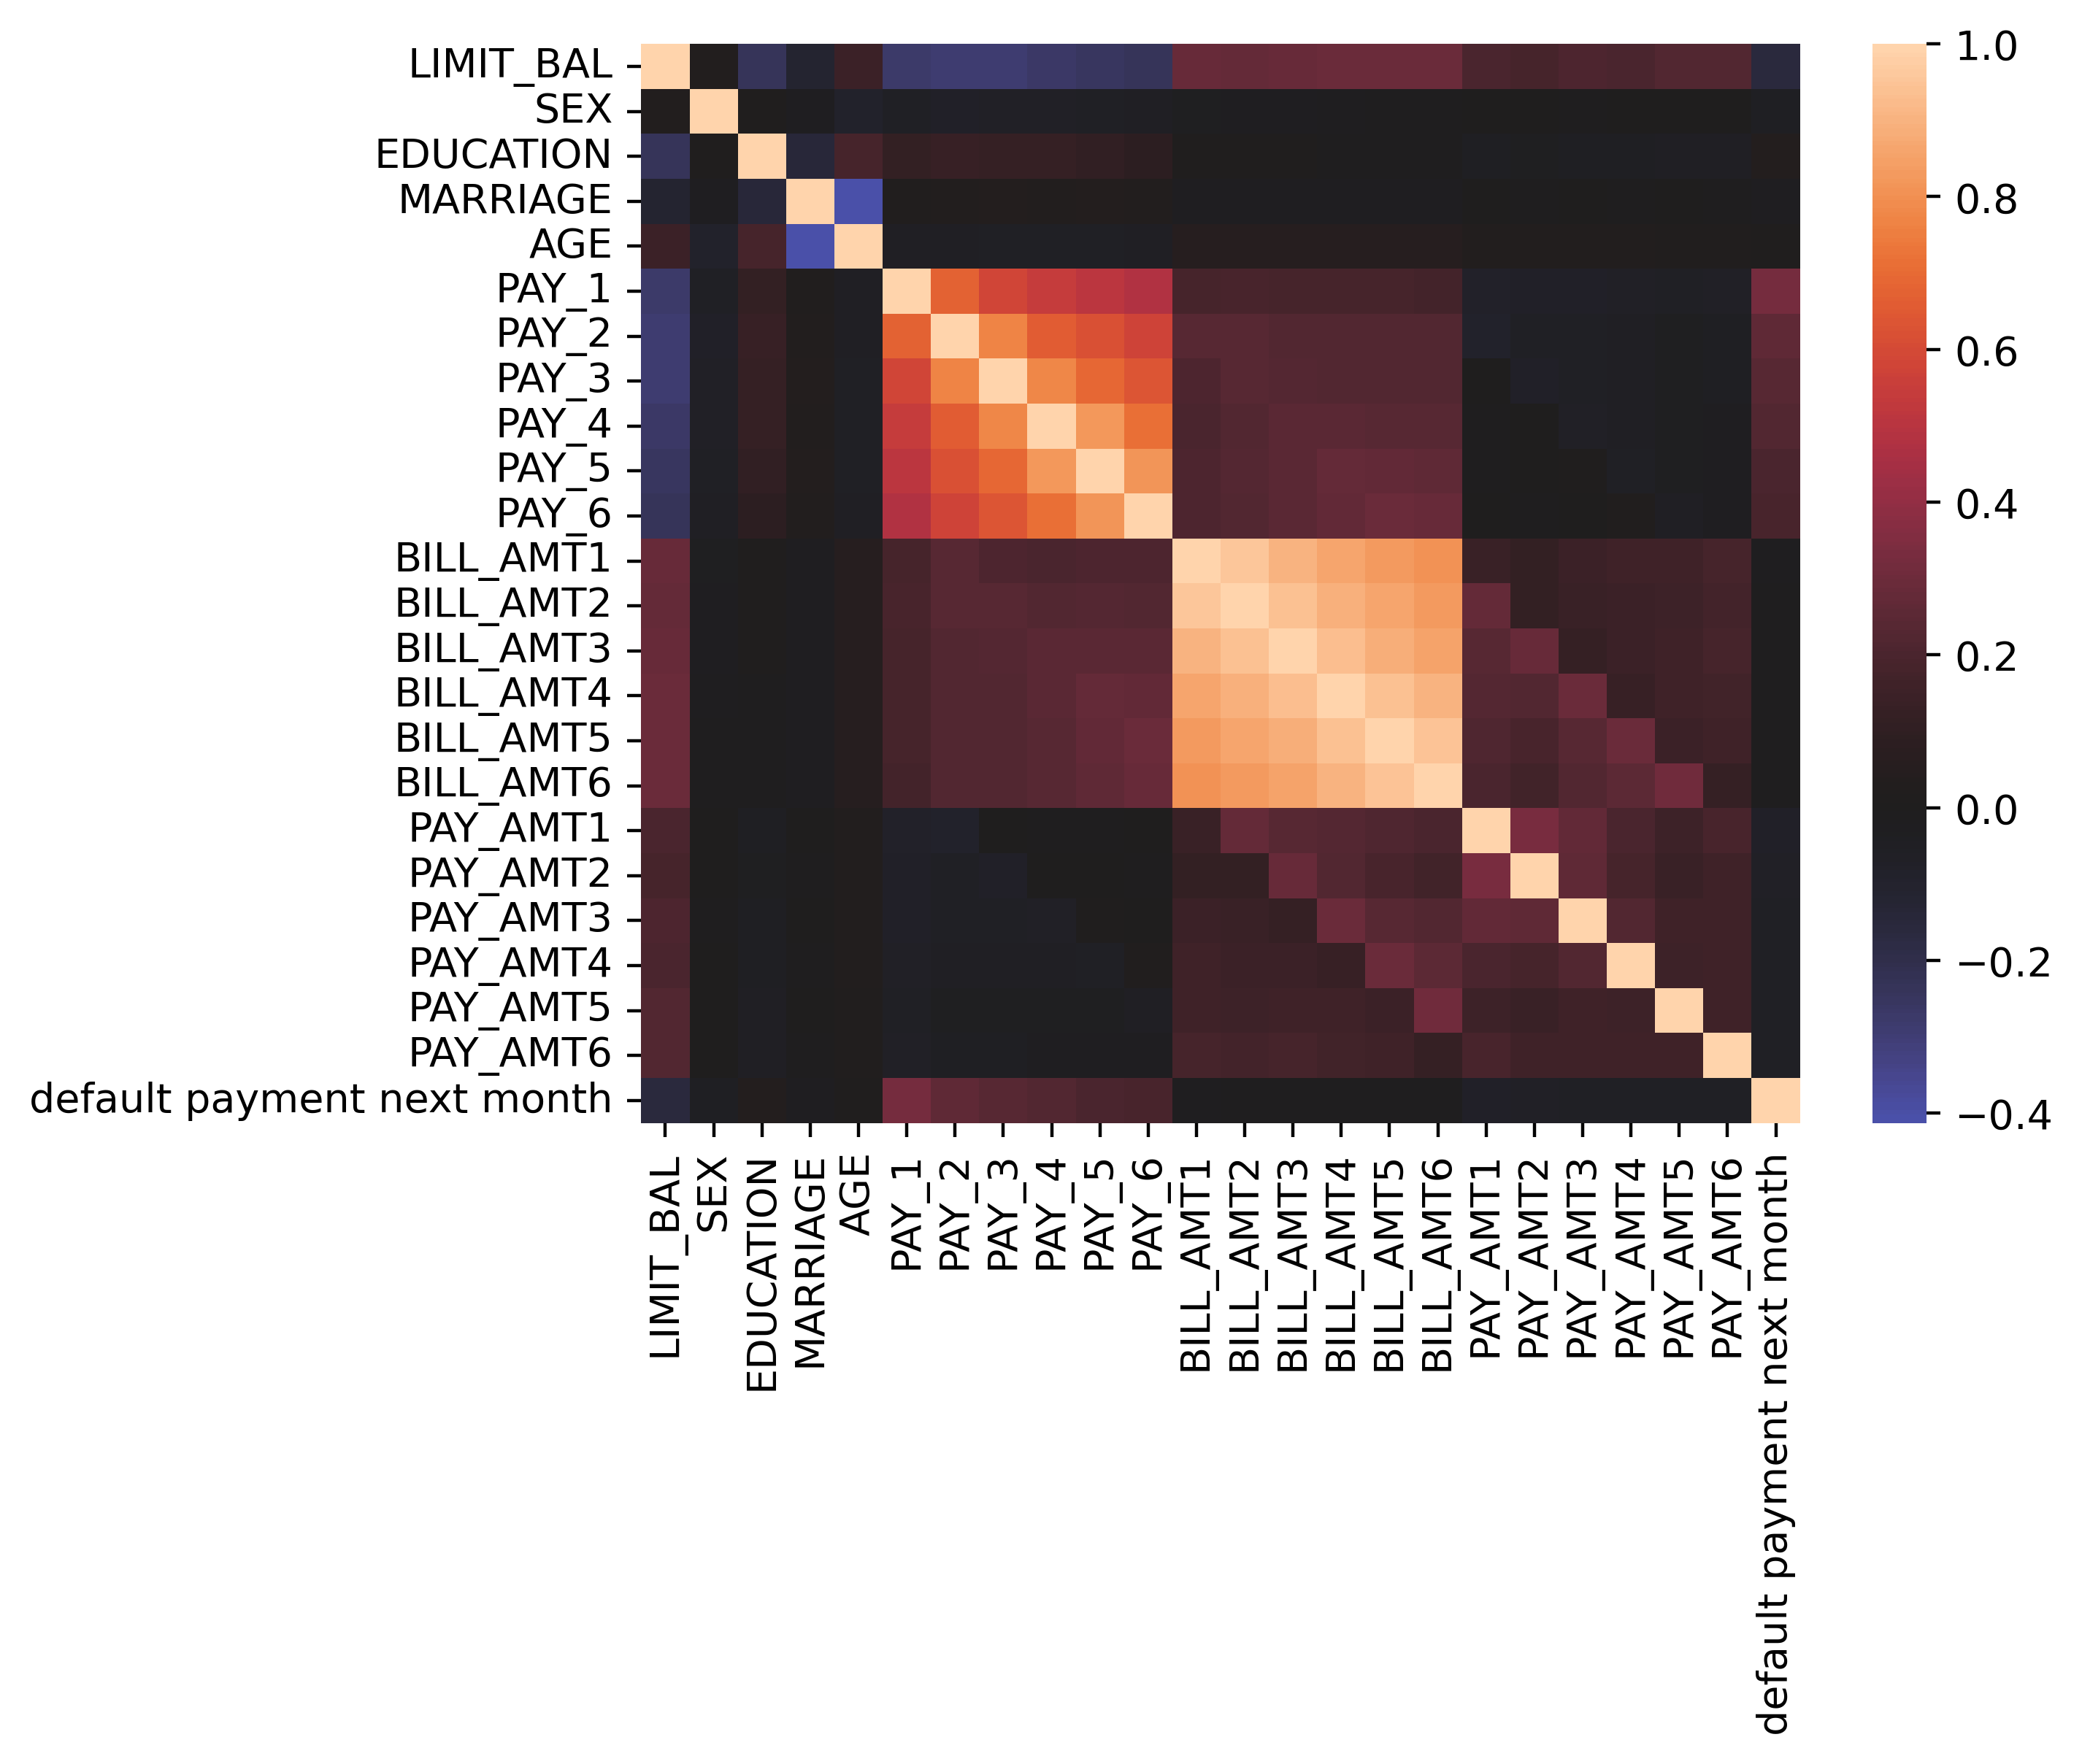

In [9]:
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, center=0)
# From heatmap, PAY_1 and LIMIT_BAL are the two features with the strongest correlation with response variable default payment next month
# PAY_1 has relatively strong positive correlation with default, whereas LIMIT_BAL has relatively strong negative correlation with default
# PAY_2 - 6 have weak, but still positive correlation with default status

In [10]:
# Pearson correlation above is not 100% approriate for this case study
# This is because data here is binary classification, whereas pearson correlation works best for continuous variables, or regresion
# the usefulness of the above is that it is easy to interpret and glean surface level analysis / information from
# Pearson correlation also only assesses linear relations, which some of the features may or may not have with the response variable

# General examining of feature strength and relation to default payment next month + univariate feature selection exploration

- F-statistic and p-values

In [11]:
# Because this case study deals with binary classification, can look to use F-statistic / p-values to perform surface level analysis.
# Provides idea of which features would be more important for modeling
X = df[features].iloc[:, :-1]
y = df[features].iloc[:, -1]

In [12]:
[f_stat, f_p_value] = f_classif(X, y)

In [13]:
f_test_df = pd.DataFrame(
    {
        'Feature': features[:-1],
        'F-statistic': f_stat,
        'p value': f_p_value
    }
)

In [14]:
f_test_df.sort_values(by='p value')
# ANOVA F-Test with corresponding p-values is employed here for ranking of feature purposes
# Higher F-statistic and lower p-value indicates that there is a significant difference in the means of the two binary classes for that given feature.
# DataFrame ranking indicates that PAY_1 and LIMIT_BAL are the two features with the greatest significance on the response variable default

# Technically, since this is a binary classification, this would just be a t-test. 
# Further, t-test and F-test assume that the data is normally distributed, which has not been explored yet.
# Additionally, in cases of multi-classification, p-values need to be shifted
# However, for the purpose of ranking the features based on p-value and not performing finalized statistical inferences, this should provide useful surface level analysis
# F-test also does not consider interactions between features that may result in lower F-statistic features having a stronger relation to the response variable

,Feature,F-statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


In [15]:
# To confirm the DataFrame above, use sklearn SelectPercentile to determine the top 20% features
selector = SelectPercentile(f_classif, percentile=20)
selector.fit(X, y)

SelectPercentile(percentile=20)

In [16]:
selector.get_support()

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [17]:
best_features = X.columns[selector.get_support()]
best_features

Index(['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2'], dtype='object')

# Visualizing Relationship Between Features & Response Variable

First, exploring PAY_1 feature. How do the default rates change based on the value of this encoded feature?

Because feature is encoded, creating a plot of default rate for each unique coded value in PAY_1 relative to an average would help visualize any trends

In [18]:
# Plotting default rates of the different 
overall_default_rate = df['default payment next month'].mean()
group_by_pay_mean_y = df.groupby(by='PAY_1').agg({'default payment next month': np.mean})

In [19]:
group_by_pay_mean_y

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


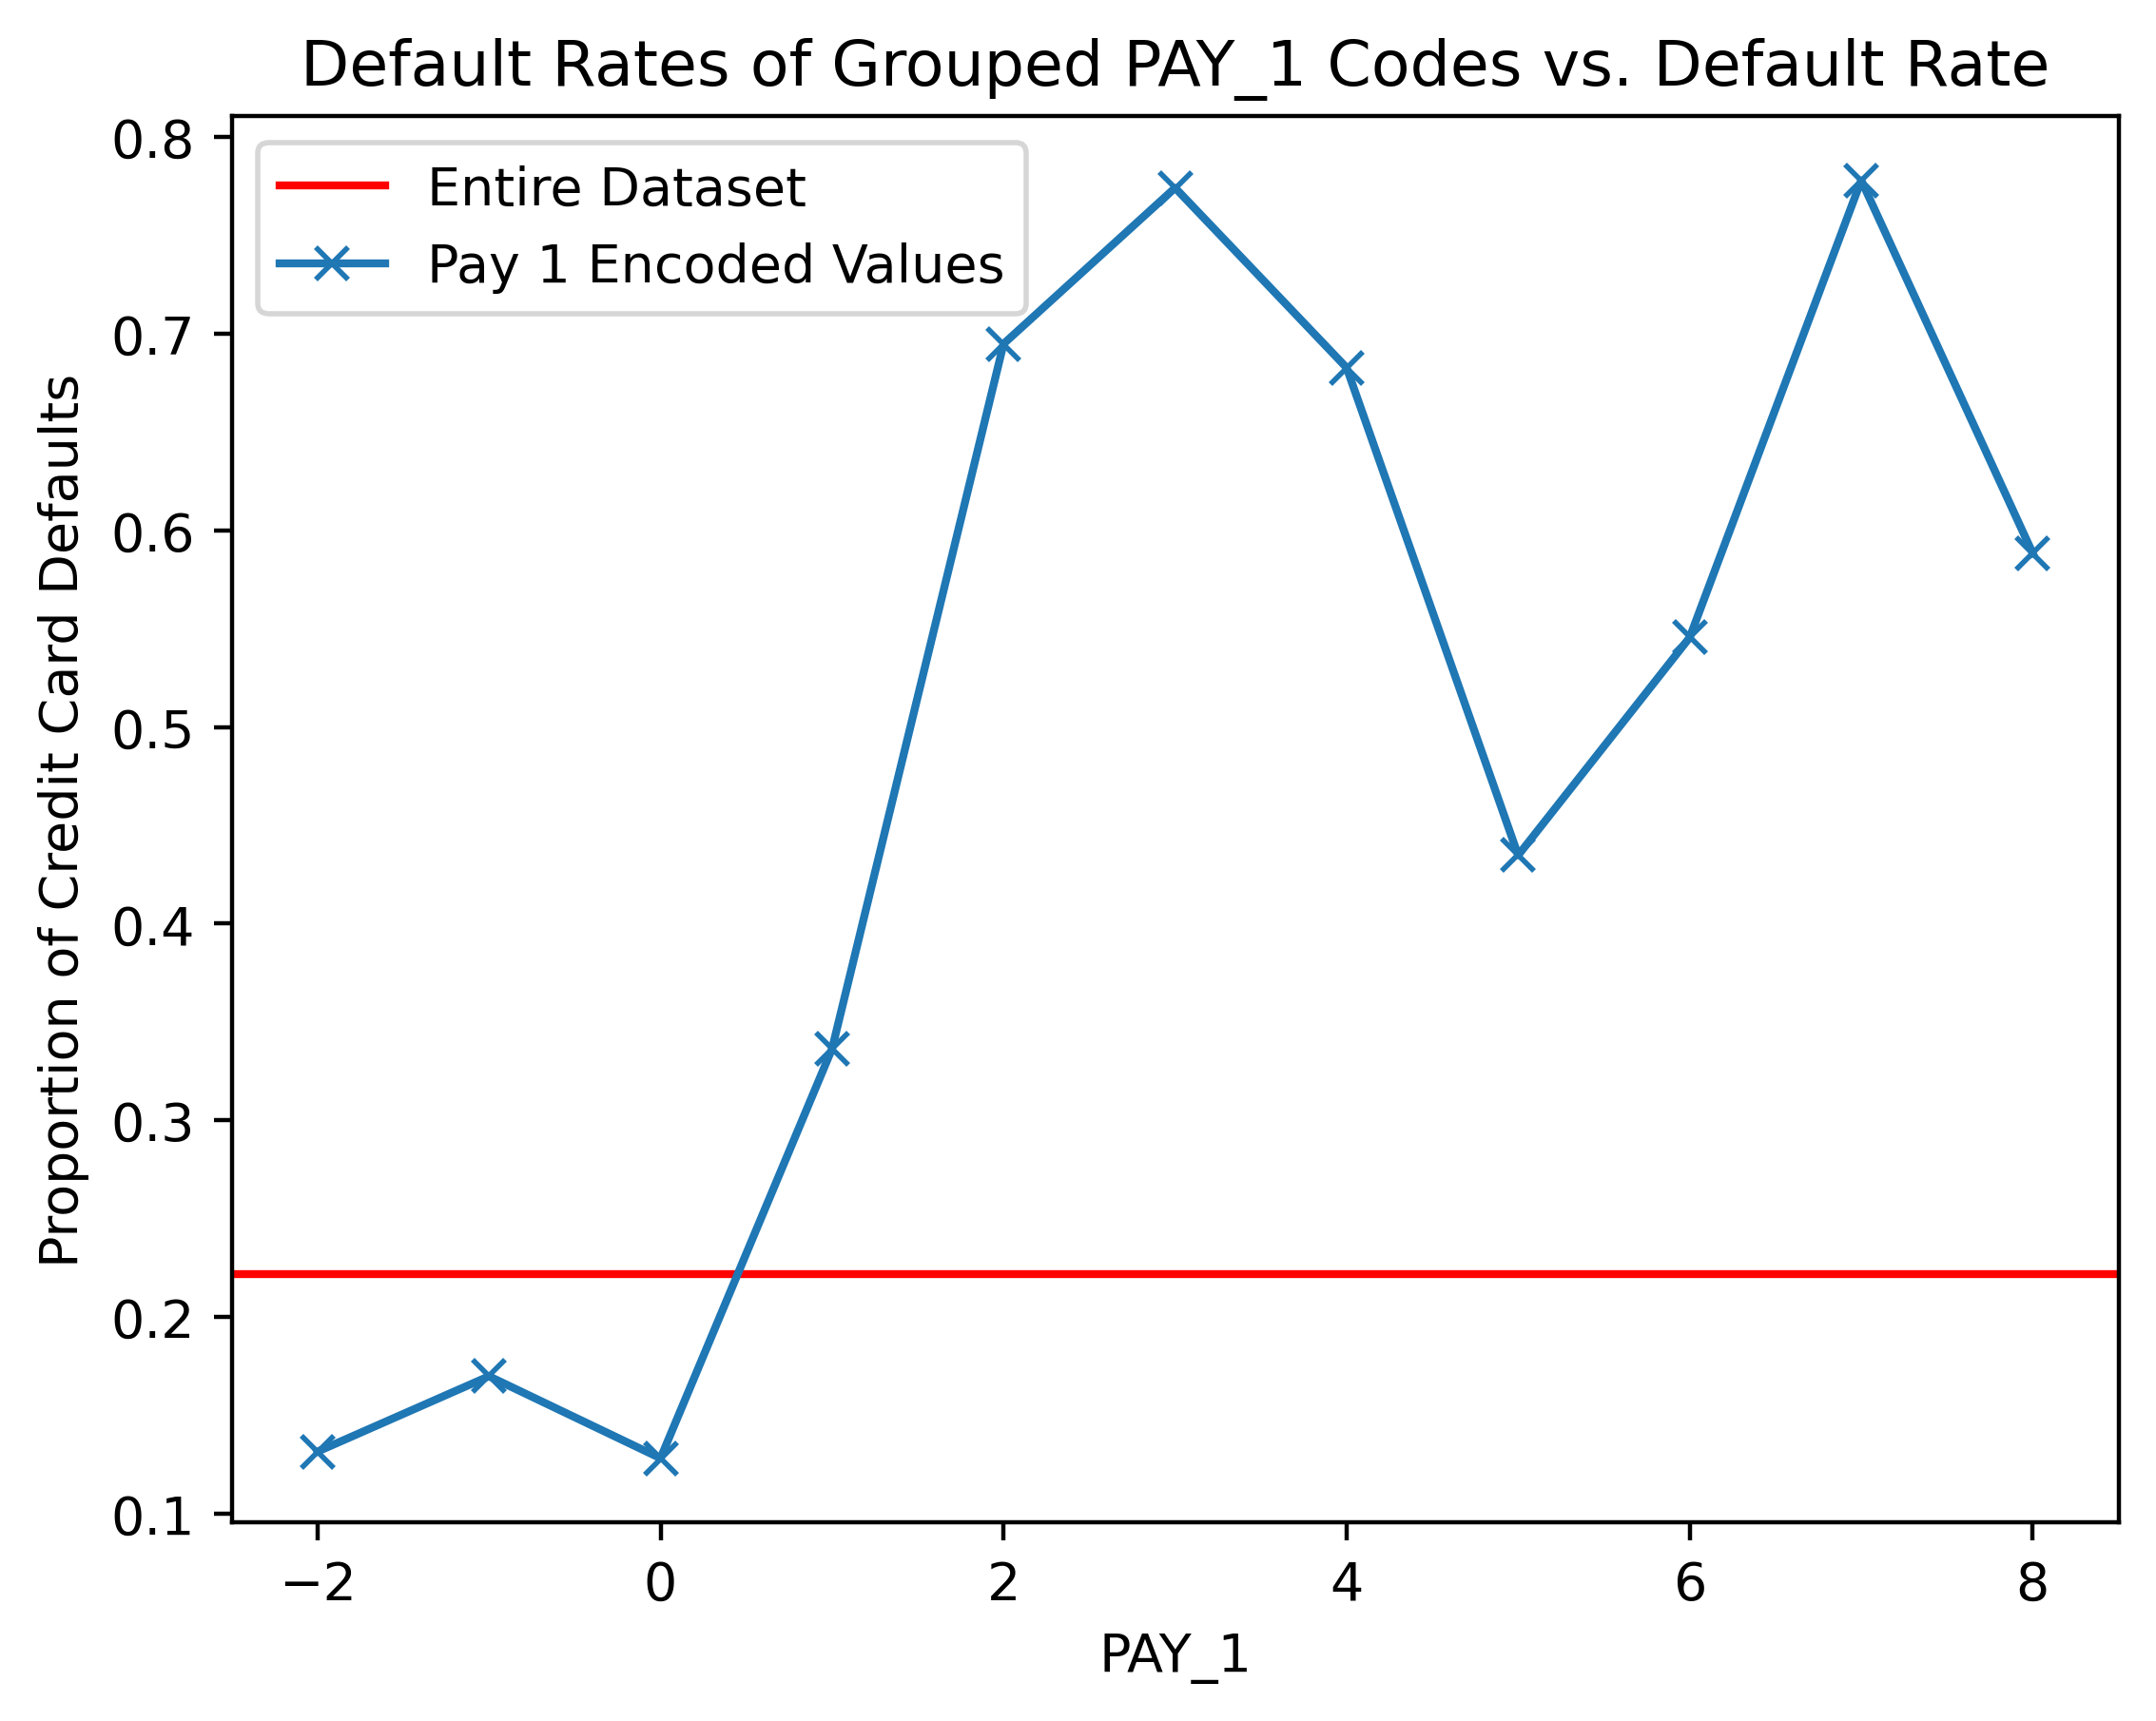

In [20]:
axes = plt.axes()
axes.axhline(overall_default_rate, color='red')
group_by_pay_mean_y.plot(marker='x', legend=False, ax=axes)
axes.set_ylabel('Proportion of Credit Card Defaults')
axes.set_title('Default Rates of Grouped PAY_1 Codes vs. Default Rate')
axes.legend(['Entire Dataset', 'Pay 1 Encoded Values'])

# From visual, it is apparent that default rates tend to climb as delinquency in payment increases. Accounts that have at least paid the monthly minimum or have paid their monthly fees duly exhibit lower default rates.
# Compared to the average default rate of the entire dataset, accounts in good standing are lower than the average default rate of the entire dataset, whereas accounts with delinquent payment statuses exhibit higher than average default rates. This means accounts that are default in this month are more likely to be in default in the next month

Exploring Limit Balance Relation to Default Rate

In this case, limit balance is a continuous variable and is not encoded like PAY_1. To visualize continuous variable values in relation to default statis (encoded response variable), can plot layered histograms to compare values between binary classes

Text(0.5, 1.0, 'Credit Limits vs Defaults')

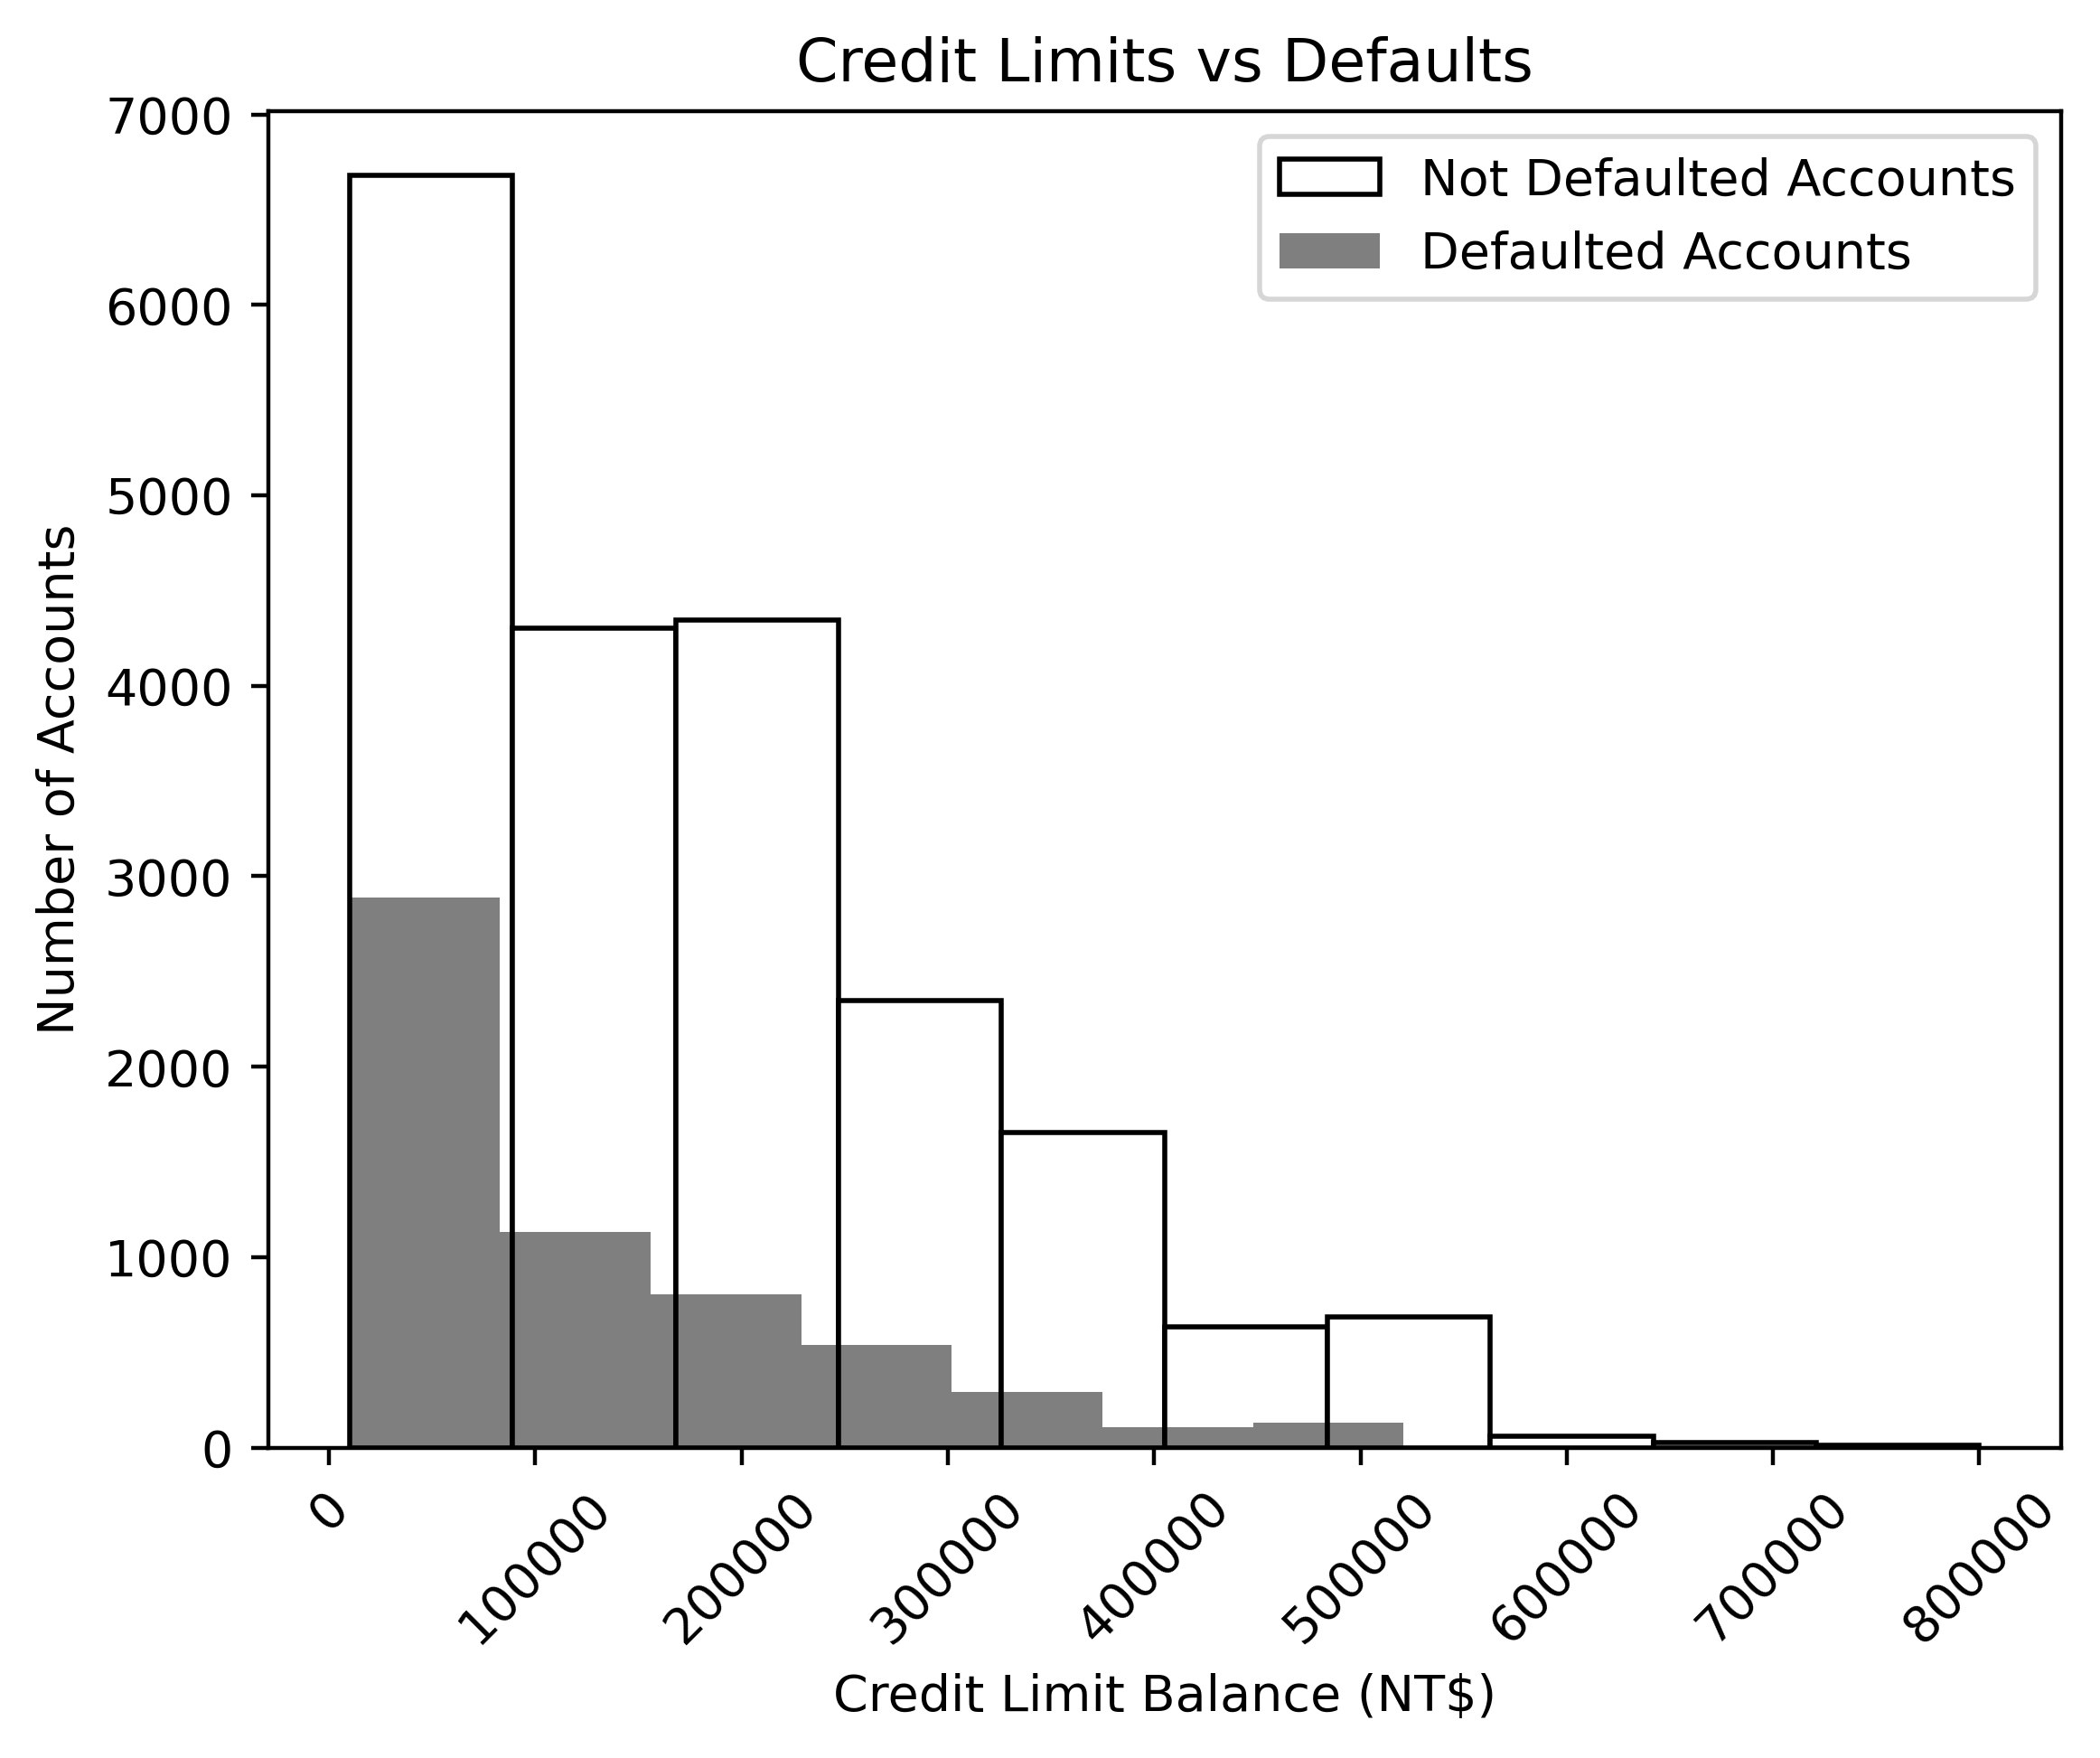

In [21]:
pos_mask = y == 1
neg_mask = y == 0

axes = plt.axes()
axes.hist(x=df.loc[neg_mask, 'LIMIT_BAL'], color='white', edgecolor='black')
axes.hist(x=df.loc[pos_mask, 'LIMIT_BAL'], alpha=0.5, color='black', edgecolor=None)
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit Limit Balance (NT$)')
axes.set_ylabel('Number of Accounts')
axes.legend(['Not Defaulted Accounts', 'Defaulted Accounts'])
axes.set_title('Credit Limits vs Defaults')

In [22]:
# The above visual helps examine the relation of limit balance with defaults. However, it is not entirely useful because there's a large discrepancy in the number of accounts that have not defaulted versus the number of accounts that have defaulted. All this tells us is the size/counts of the histograms and not the shape of the histograms.

# One solution can be normalizing the data, which makes the area of the two histograms the same. Using probability mass functions, we can ensure that the itegral of the histograms will be equal to 1 after normalization. This makes sense logically because probabilities, in total, sum to 1.

In [23]:
bin_edges = list(range(0, max(df['LIMIT_BAL']) + 50000, 50000))

In [24]:
print(bin_edges)

[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000]


FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Normalized distributions of credit limits by response variable')

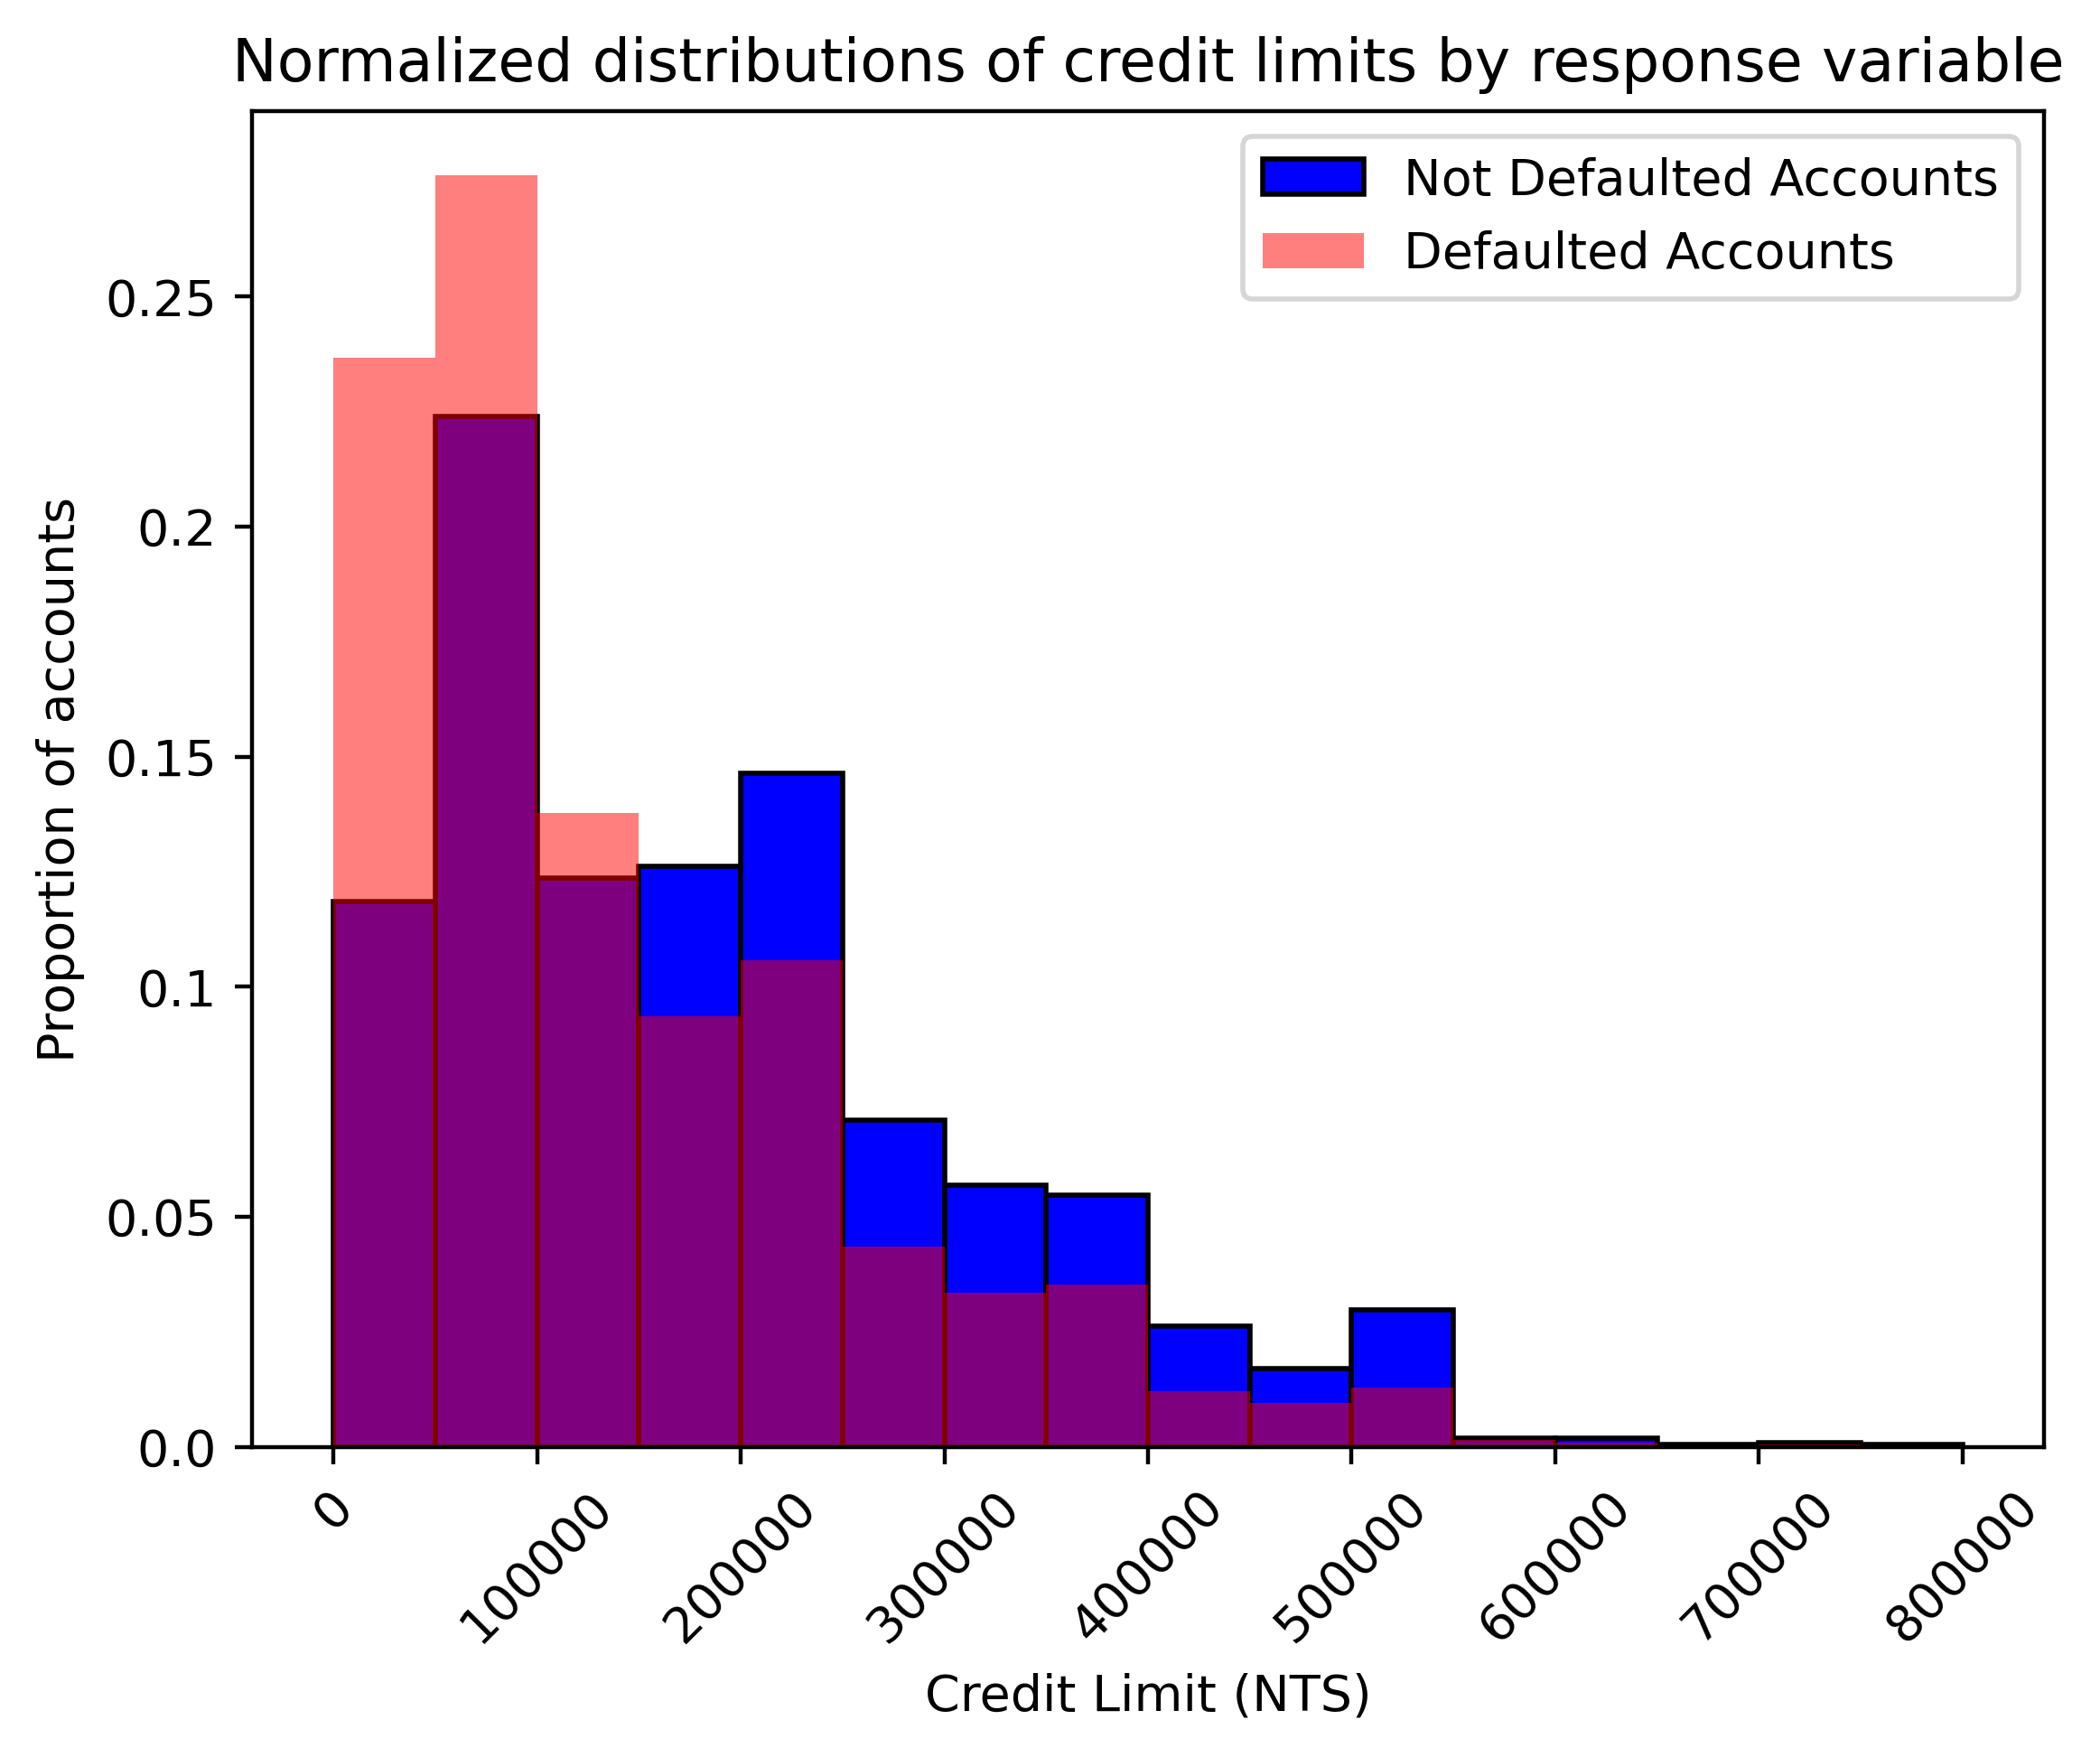

In [25]:
axes = plt.axes()
axes.hist(x=df.loc[neg_mask, 'LIMIT_BAL'], bins=bin_edges, density=True, color='blue', edgecolor='black')
axes.hist(x=df.loc[pos_mask, 'LIMIT_BAL'], bins=bin_edges, density=True, color='red', alpha=0.5)
axes.tick_params(axis='x', labelrotation=45)
y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks * 50000, 2))
axes.legend(['Not Defaulted Accounts', 'Defaulted Accounts'])
axes.set_ylabel('Proportion of accounts')
axes.set_xlabel('Credit Limit (NTS)')
axes.set_title('Normalized distributions of credit limits by response variable')

In [26]:
# From the normalized distribution, it is apparent that accounts with lower credit limits exhibit higher proportions of defaulting vs. accounts with higher credit limits that have higher proportions of not defaulting.

In [27]:
# To reiterate, the above methods of data examination are just to get a quick idea of the relationship of features with the response variable
# There are statistical assumptions that methods such as T-test and p-value examination that must be explored before performing statistical inferences. The above methods are just surface level analysis of features. 
# Another aspect of the data we can look at is if a feature like PAY_1 is linear with log odds (log(p/q/) = linear combination of input features; as derived from logistic regression)

# Examining Appropriateness of Logistic Regression

Text(0.5, 0, 'Values of PAY_1')

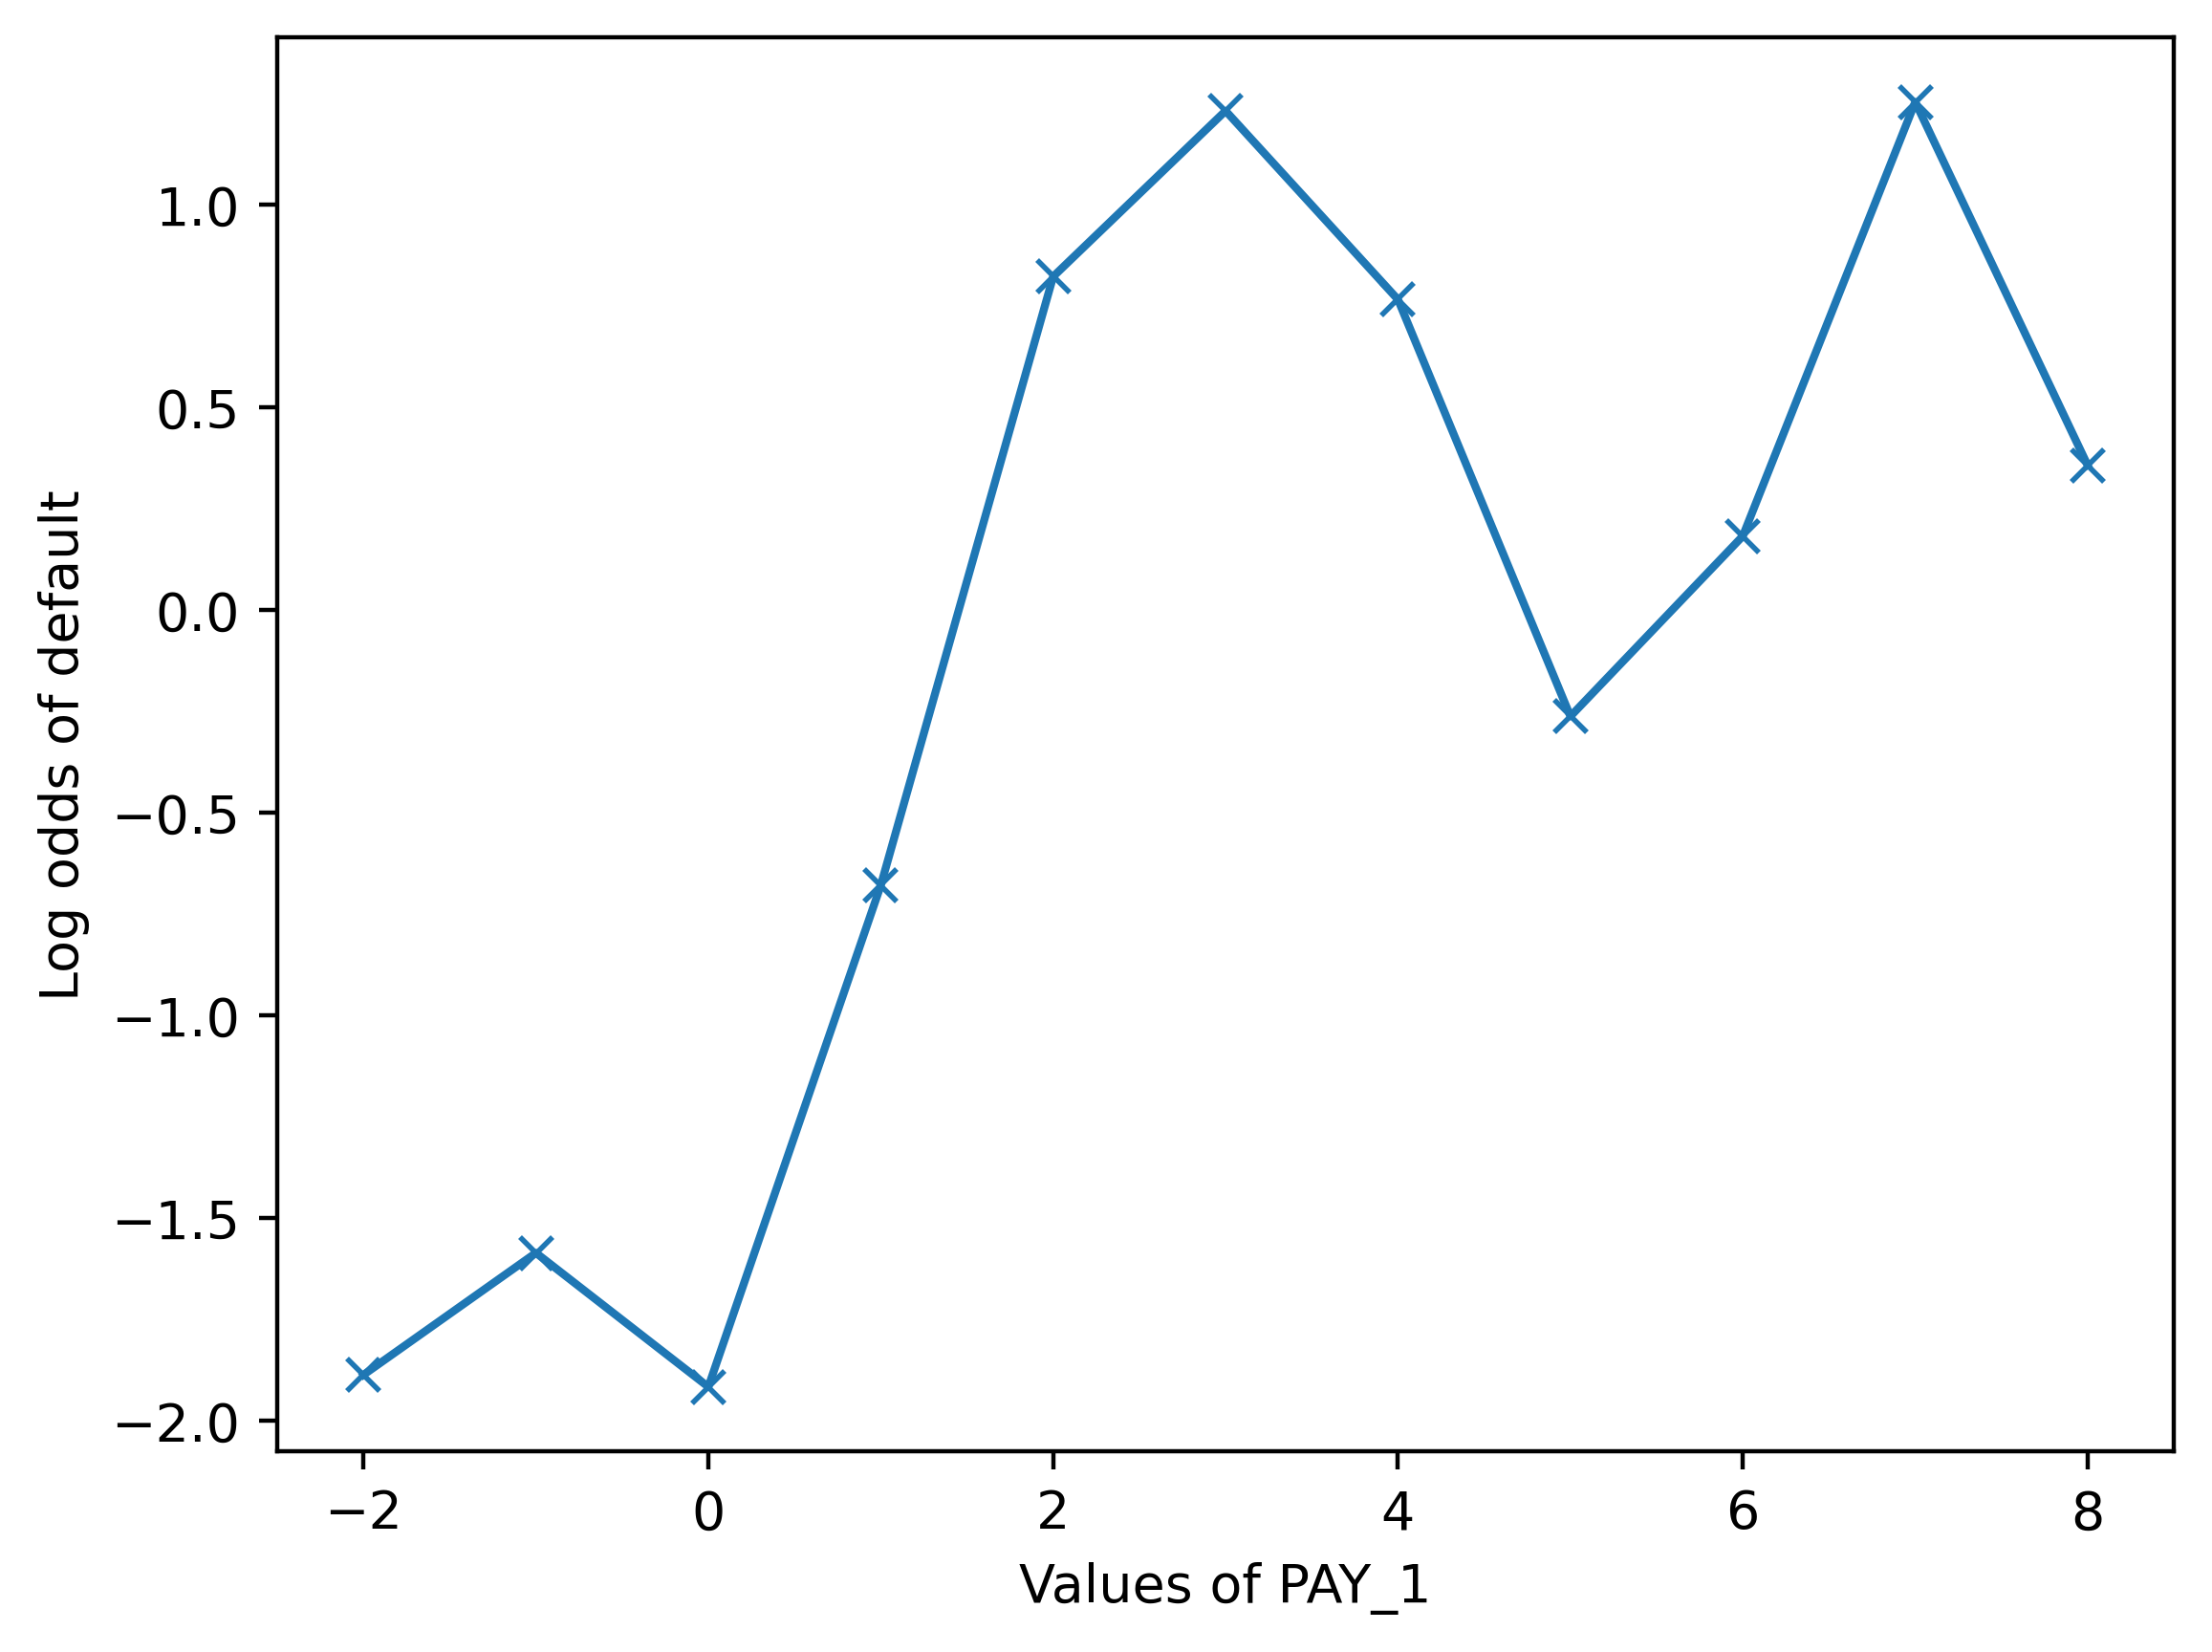

In [28]:
# In logistic regression, 'p' represents the probability the sample is positive (1), and 'q' represents 1 - p, or the probability that the sample is negative.
p = group_by_pay_mean_y
q = 1 - p
odds_ratio = p / q
log_odds = np.log(odds_ratio)
plt.plot(group_by_pay_mean_y.index, log_odds, '-x')
plt.ylabel('Log odds of default')
plt.xlabel('Values of PAY_1')
# From the plot below, there is a linear trend as the value of PAY_1 progresses sequentially. This means that the data may be appropriate for logistic regression.  
# Perhaps some data transformations or even a different means of encoding -2, -1, and 0 would help with modeling.

# Cross Validation & Feature Engineering

In [29]:
sum(df['default payment next month'] == 1)

5914

In [30]:
# Following rule of 10, for less observed class (positive default, or 1 coding) there are 5914 samples. A rule of 10 would suggest 50 or so features, whereas the data we have trimmed down because of business understandings and data source issues contains 17 features. 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df[features[:-1]].values, df[features[-1]].values, test_size=0.20, random_state=24)

In [32]:
print('X Train Shape: {} \nX_test.shape: {}'.format(X_train.shape, X_test.shape))

X Train Shape: (21331, 17) 
X_test.shape: (5333, 17)


In [33]:
print('y Train Shape: {} \ny_test.shape: {}'.format(y_train.shape, y_test.shape))

y Train Shape: (21331,) 
y_test.shape: (5333,)


In [34]:
min_max_sc = MinMaxScaler()

In [35]:
lr = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)  # Setting iterations for gradient descent, under the hood parameter convergence

In [36]:
scale_lr_pipeline = Pipeline(
    steps = [
        ('scaler', min_max_sc),
        ('model', lr)
    ]
)

In [37]:
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [38]:
scale_lr_pipeline.get_params()['model__C']

1.0

In [39]:
scale_lr_pipeline.set_params(model__C=2)
# Recall C controls the weight of prediction errors on parameter tuning of logistic regression log odds
# Above is an example of how to change parameter of pipeline model

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [40]:
C_val_exponents = np.linspace(2, -3, 6)
C_vals = np.float(10)**C_val_exponents  # Generating list of C parameter values for CV

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [41]:
k_folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

In [42]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    '''
    Performs k-fold cross-validation for various C values for a given pipeline model. Returns ROC AUC scores and ROC TPR, FPR, and threshold values for each fold iteration for each C value.
    '''
    n_folds = k_folds.n_splits
    # Create empty lists for storing scores
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]] * len(C_vals)
    #Begin looping through C-values for lr model
    for c_val_counter in range(len(C_vals)):
        pipeline.set_params(model__C=C_vals[c_val_counter])  # Set C value for pipeline
        fold_counter = 0  # Establishing index counter for current fold
        for train_index, test_index in k_folds.split(X, Y):
            # Set train and test sets for current fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            # Fit model to train
            pipeline.fit(X_cv_train, y_cv_train)
            # Acquire ROC AUC scores for train (used for over/under fitting evaluation)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, pipeline.predict_proba(X_cv_train)[:, 1])
            # Acquire ROC AUC scores for test 
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, pipeline.predict_proba(X_cv_test)[:, 1])
            # Acquire ROC curves for each fold. Array is built different for selecting best possible C-value based on CV scores and then plotting FPR vs TPR to establish performance with varying thresholds
            cv_test_roc[c_val_counter].append(roc_curve(y_cv_test, pipeline.predict_proba(X_cv_test)[:, 1]))
            # Iterate fold index tracker
            fold_counter += 1
        # Progress tracking
        print('Done with C = {}'.format(C_vals[c_val_counter]))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [43]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds=k_folds, C_vals=C_vals, pipeline=scale_lr_pipeline, X=X_train, Y=y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


In [44]:
np.mean(cv_train_roc_auc, axis=0)

array([0.71987409, 0.71967569, 0.71801243, 0.71543105, 0.71644945,
       0.5       ])

In [45]:
np.mean(cv_test_roc_auc, axis=0)


array([0.71874806, 0.71857034, 0.71696866, 0.71511112, 0.7164791 ,
       0.5       ])

Text(0.5, 1.0, 'Cross Validation Train/Test Scores')

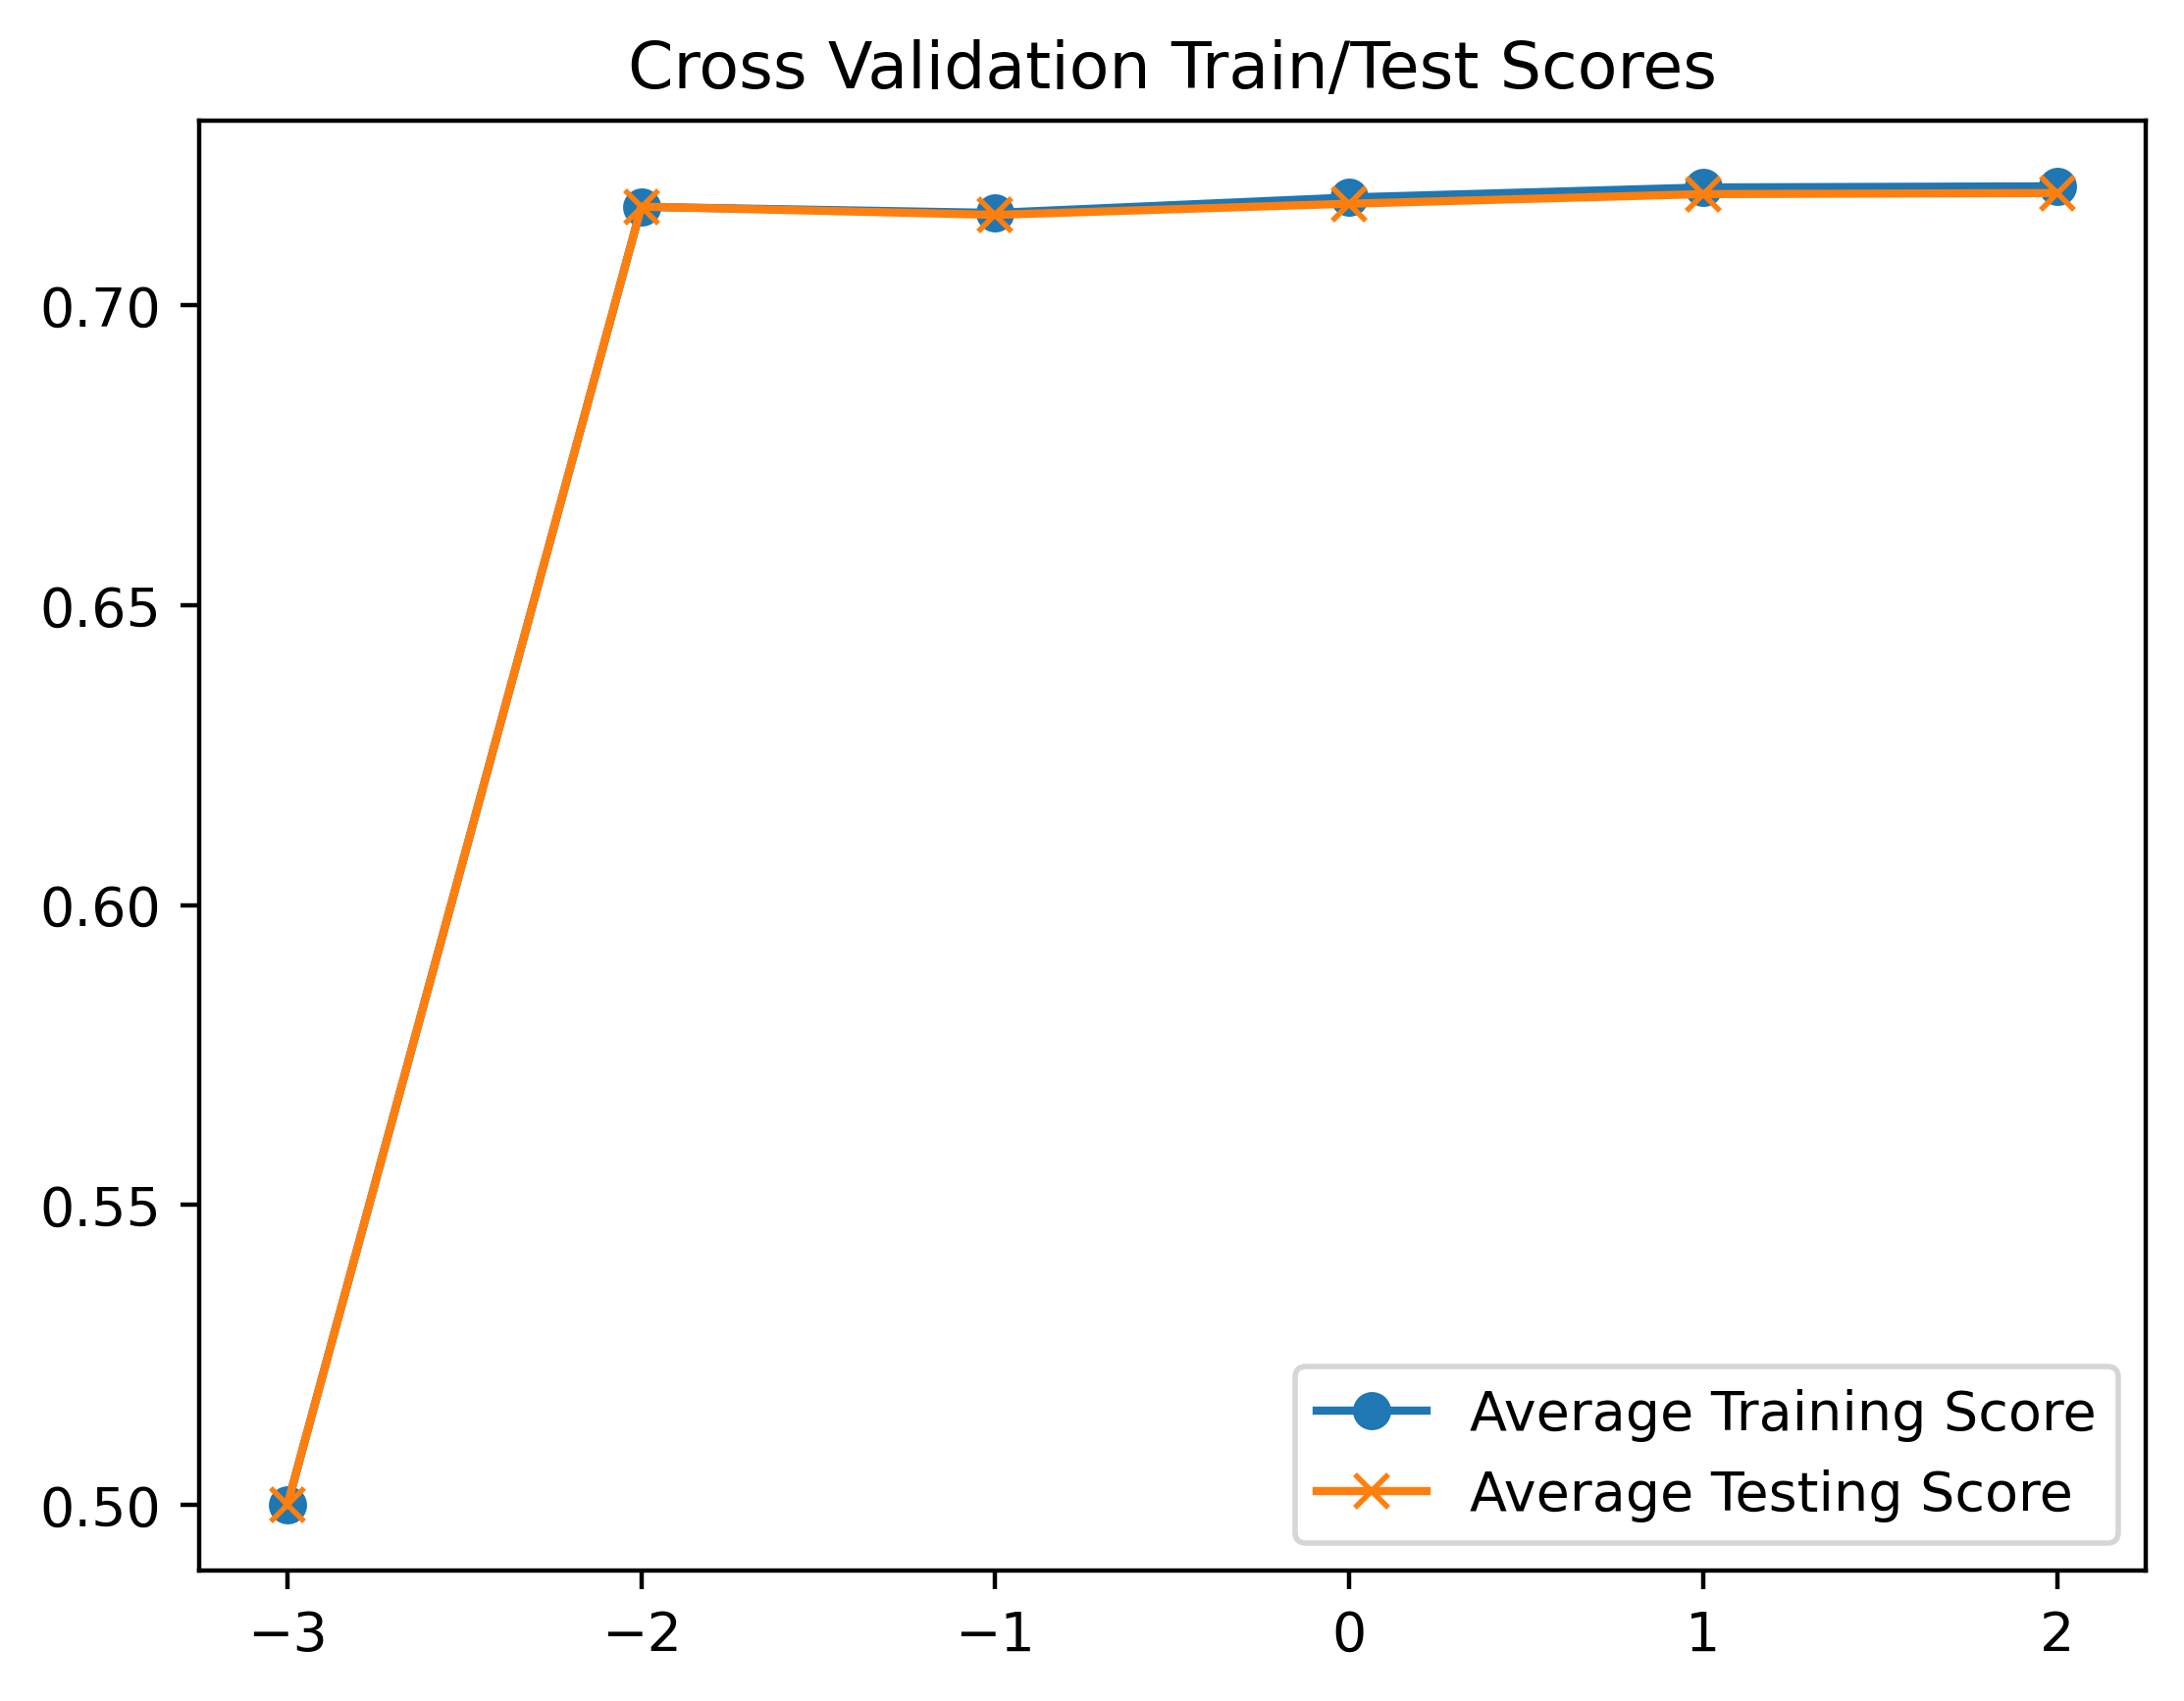

In [46]:
# Plotting CV results for train and test cross validation sets
# Use C value exoinents as x-axis, plotting the average CV performance across all 4 splits in data (average scores by row)
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o', label='Average Training Score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x', label='Average Testing Score')
plt.legend()
plt.title('Cross Validation Train/Test Scores')

In [47]:
# No large discrepancy in cross validation of train and test data; no visible overfitting occurring. Low ROC AUC scores may be a sign of underfitting. 
# As previously mentioned, feature engineering to boost features could enable higher ROC AUC scores and mitigate underfitting

In [48]:
make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interact = make_interactions.fit_transform(X)

In [49]:
X_interact.shape

(26664, 153)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_interact, df['default payment next month'].values, test_size=0.2, random_state=24)

In [51]:
print('X Train Shape: {} \nX_test.shape: {}'.format(X_train.shape, X_test.shape))
print('y Train Shape: {} \ny_test.shape: {}'.format(y_train.shape, y_test.shape))

X Train Shape: (21331, 153) 
X_test.shape: (5333, 153)
y Train Shape: (21331,) 
y_test.shape: (5333,)


In [52]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds=k_folds, C_vals=C_vals, pipeline=scale_lr_pipeline, X=X_train, Y=y_train)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


Done with C = 100.0


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


Done with C = 10.0


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


Text(0.5, 1.0, 'Cross Validation Train/Test Scores')

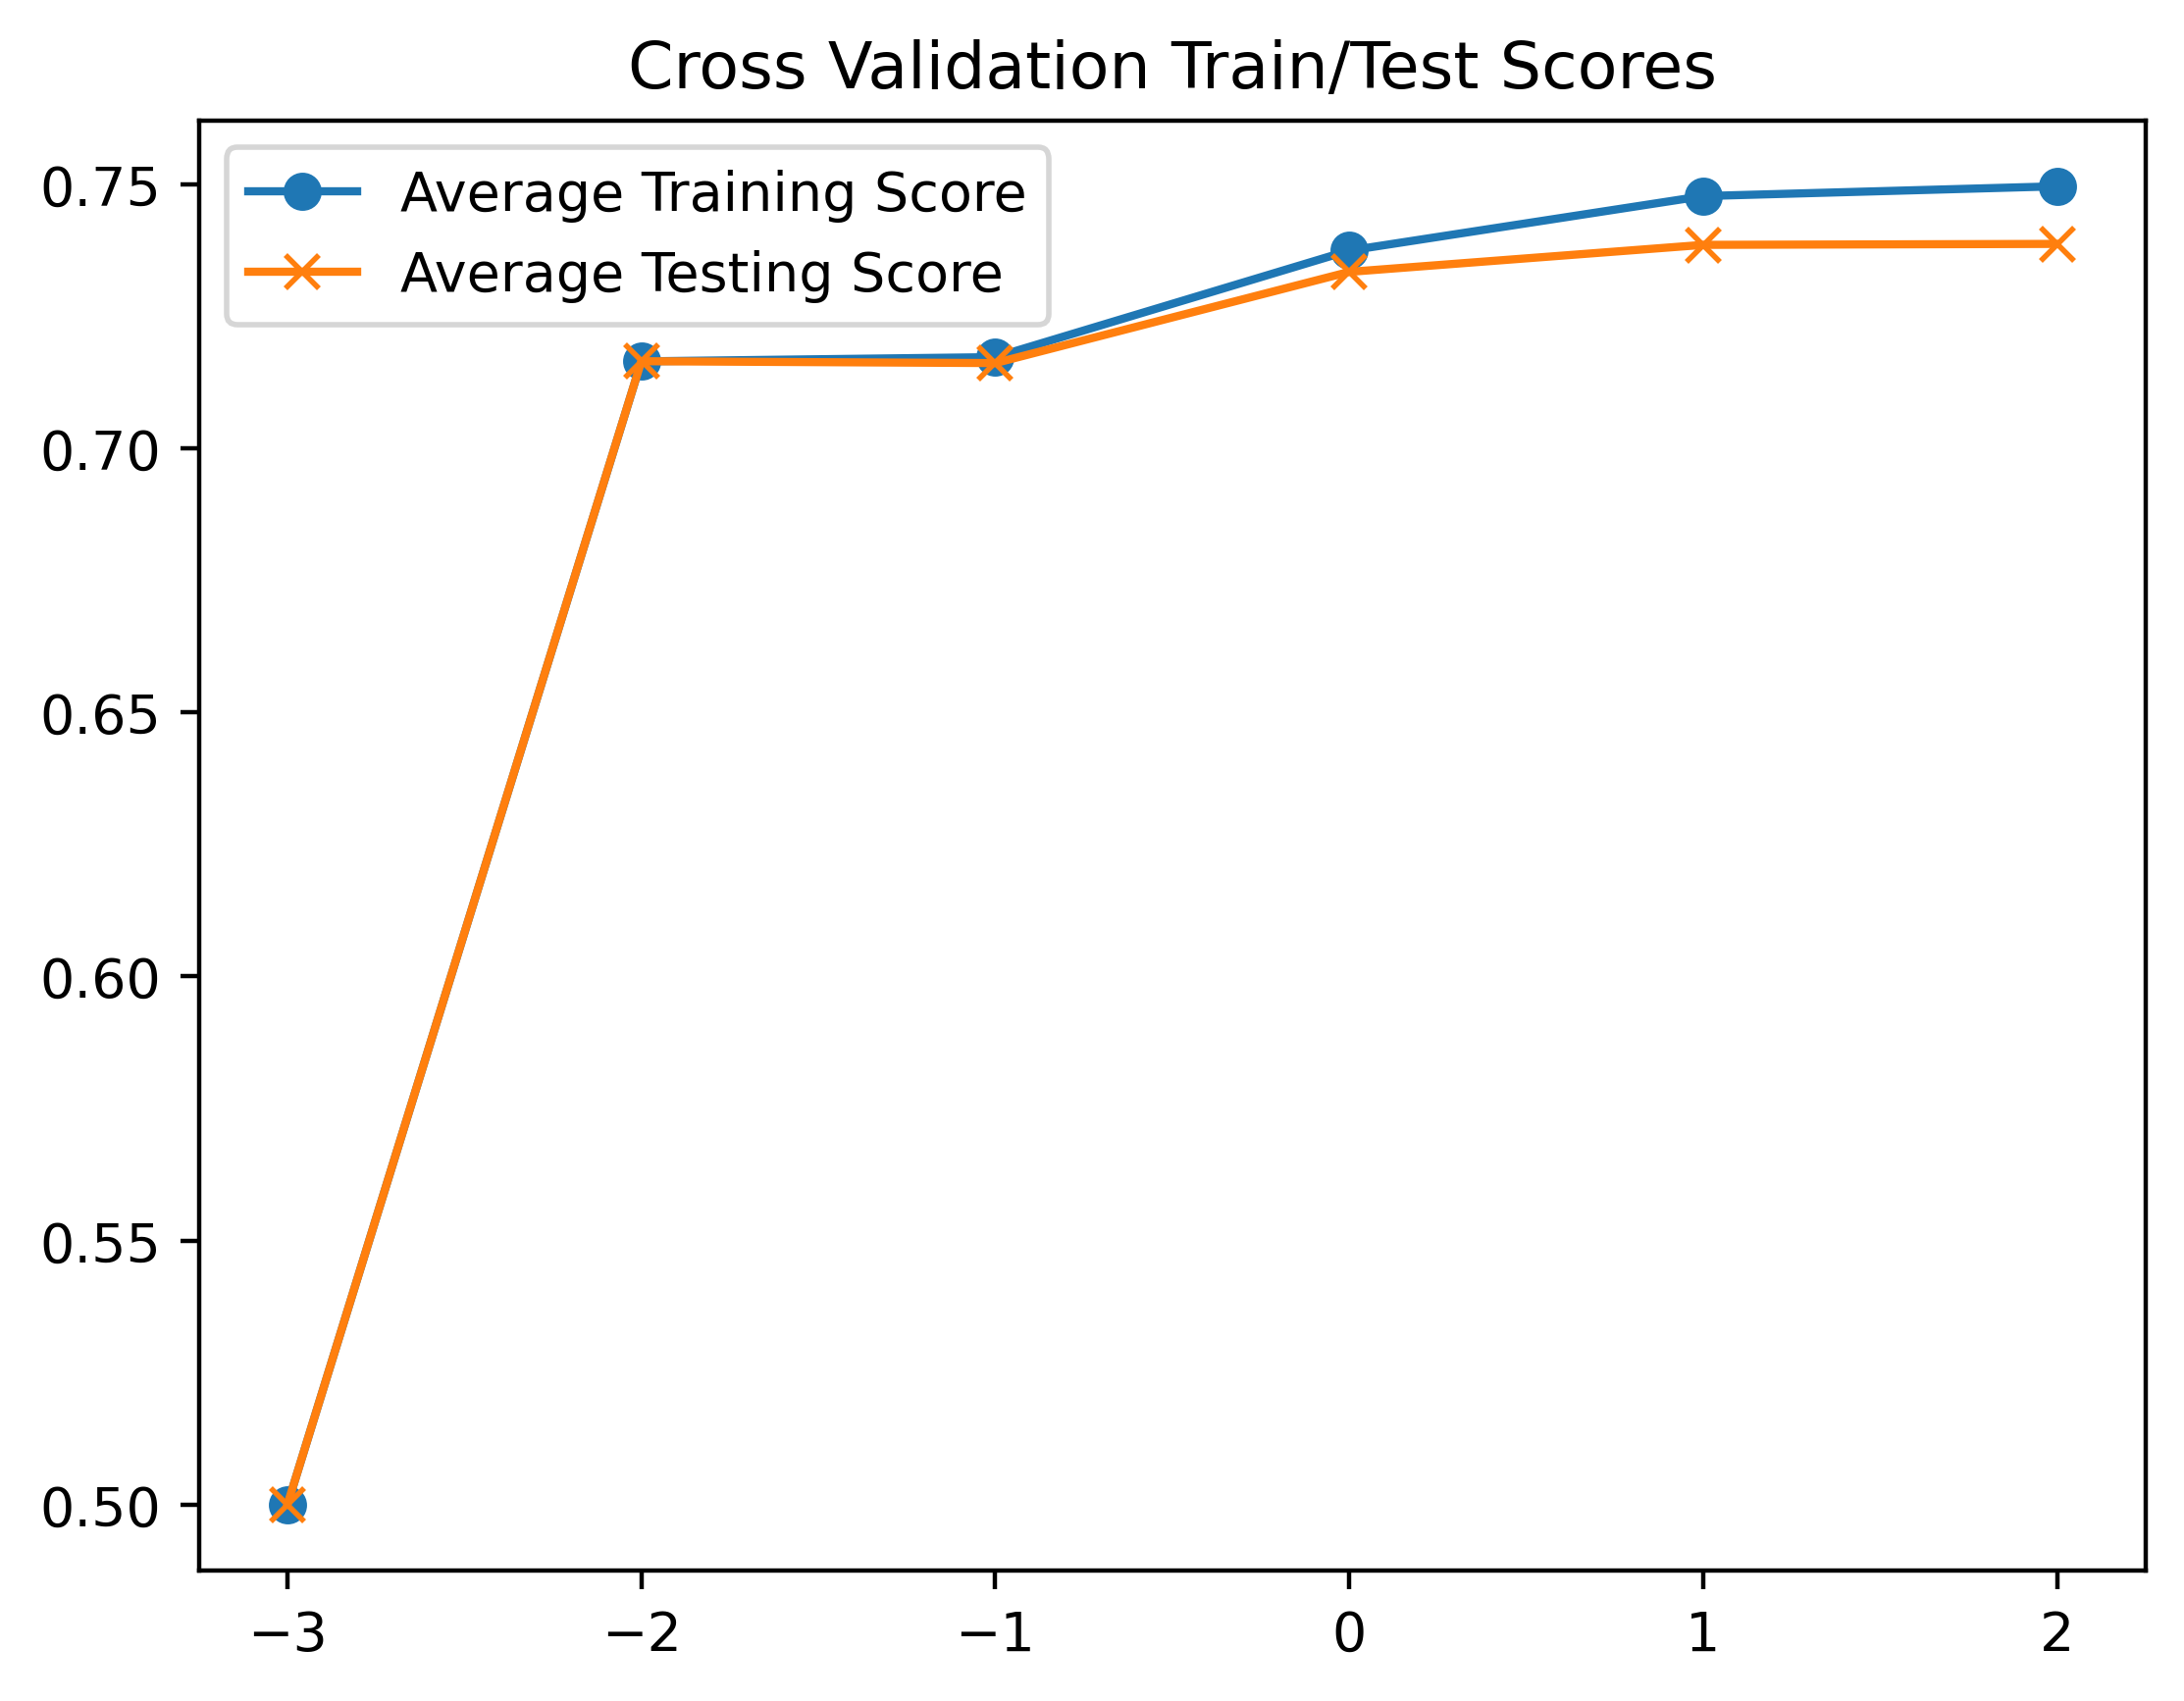

In [53]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o', label='Average Training Score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x', label='Average Testing Score')
plt.legend()
plt.title('Cross Validation Train/Test Scores')

In [54]:
np.mean(cv_test_roc_auc, axis=0)
# From plot above, 

array([0.7386904 , 0.73850691, 0.73339359, 0.71612772, 0.7164791 ,
       0.5       ])

In [55]:
best_c_val_bool = C_val_exponents == -1 
best_c_val_ix = np.nonzero(best_c_val_bool.astype(int))  # Returns index of c_val_exp=1
best_c_val_ix[0][0]

3

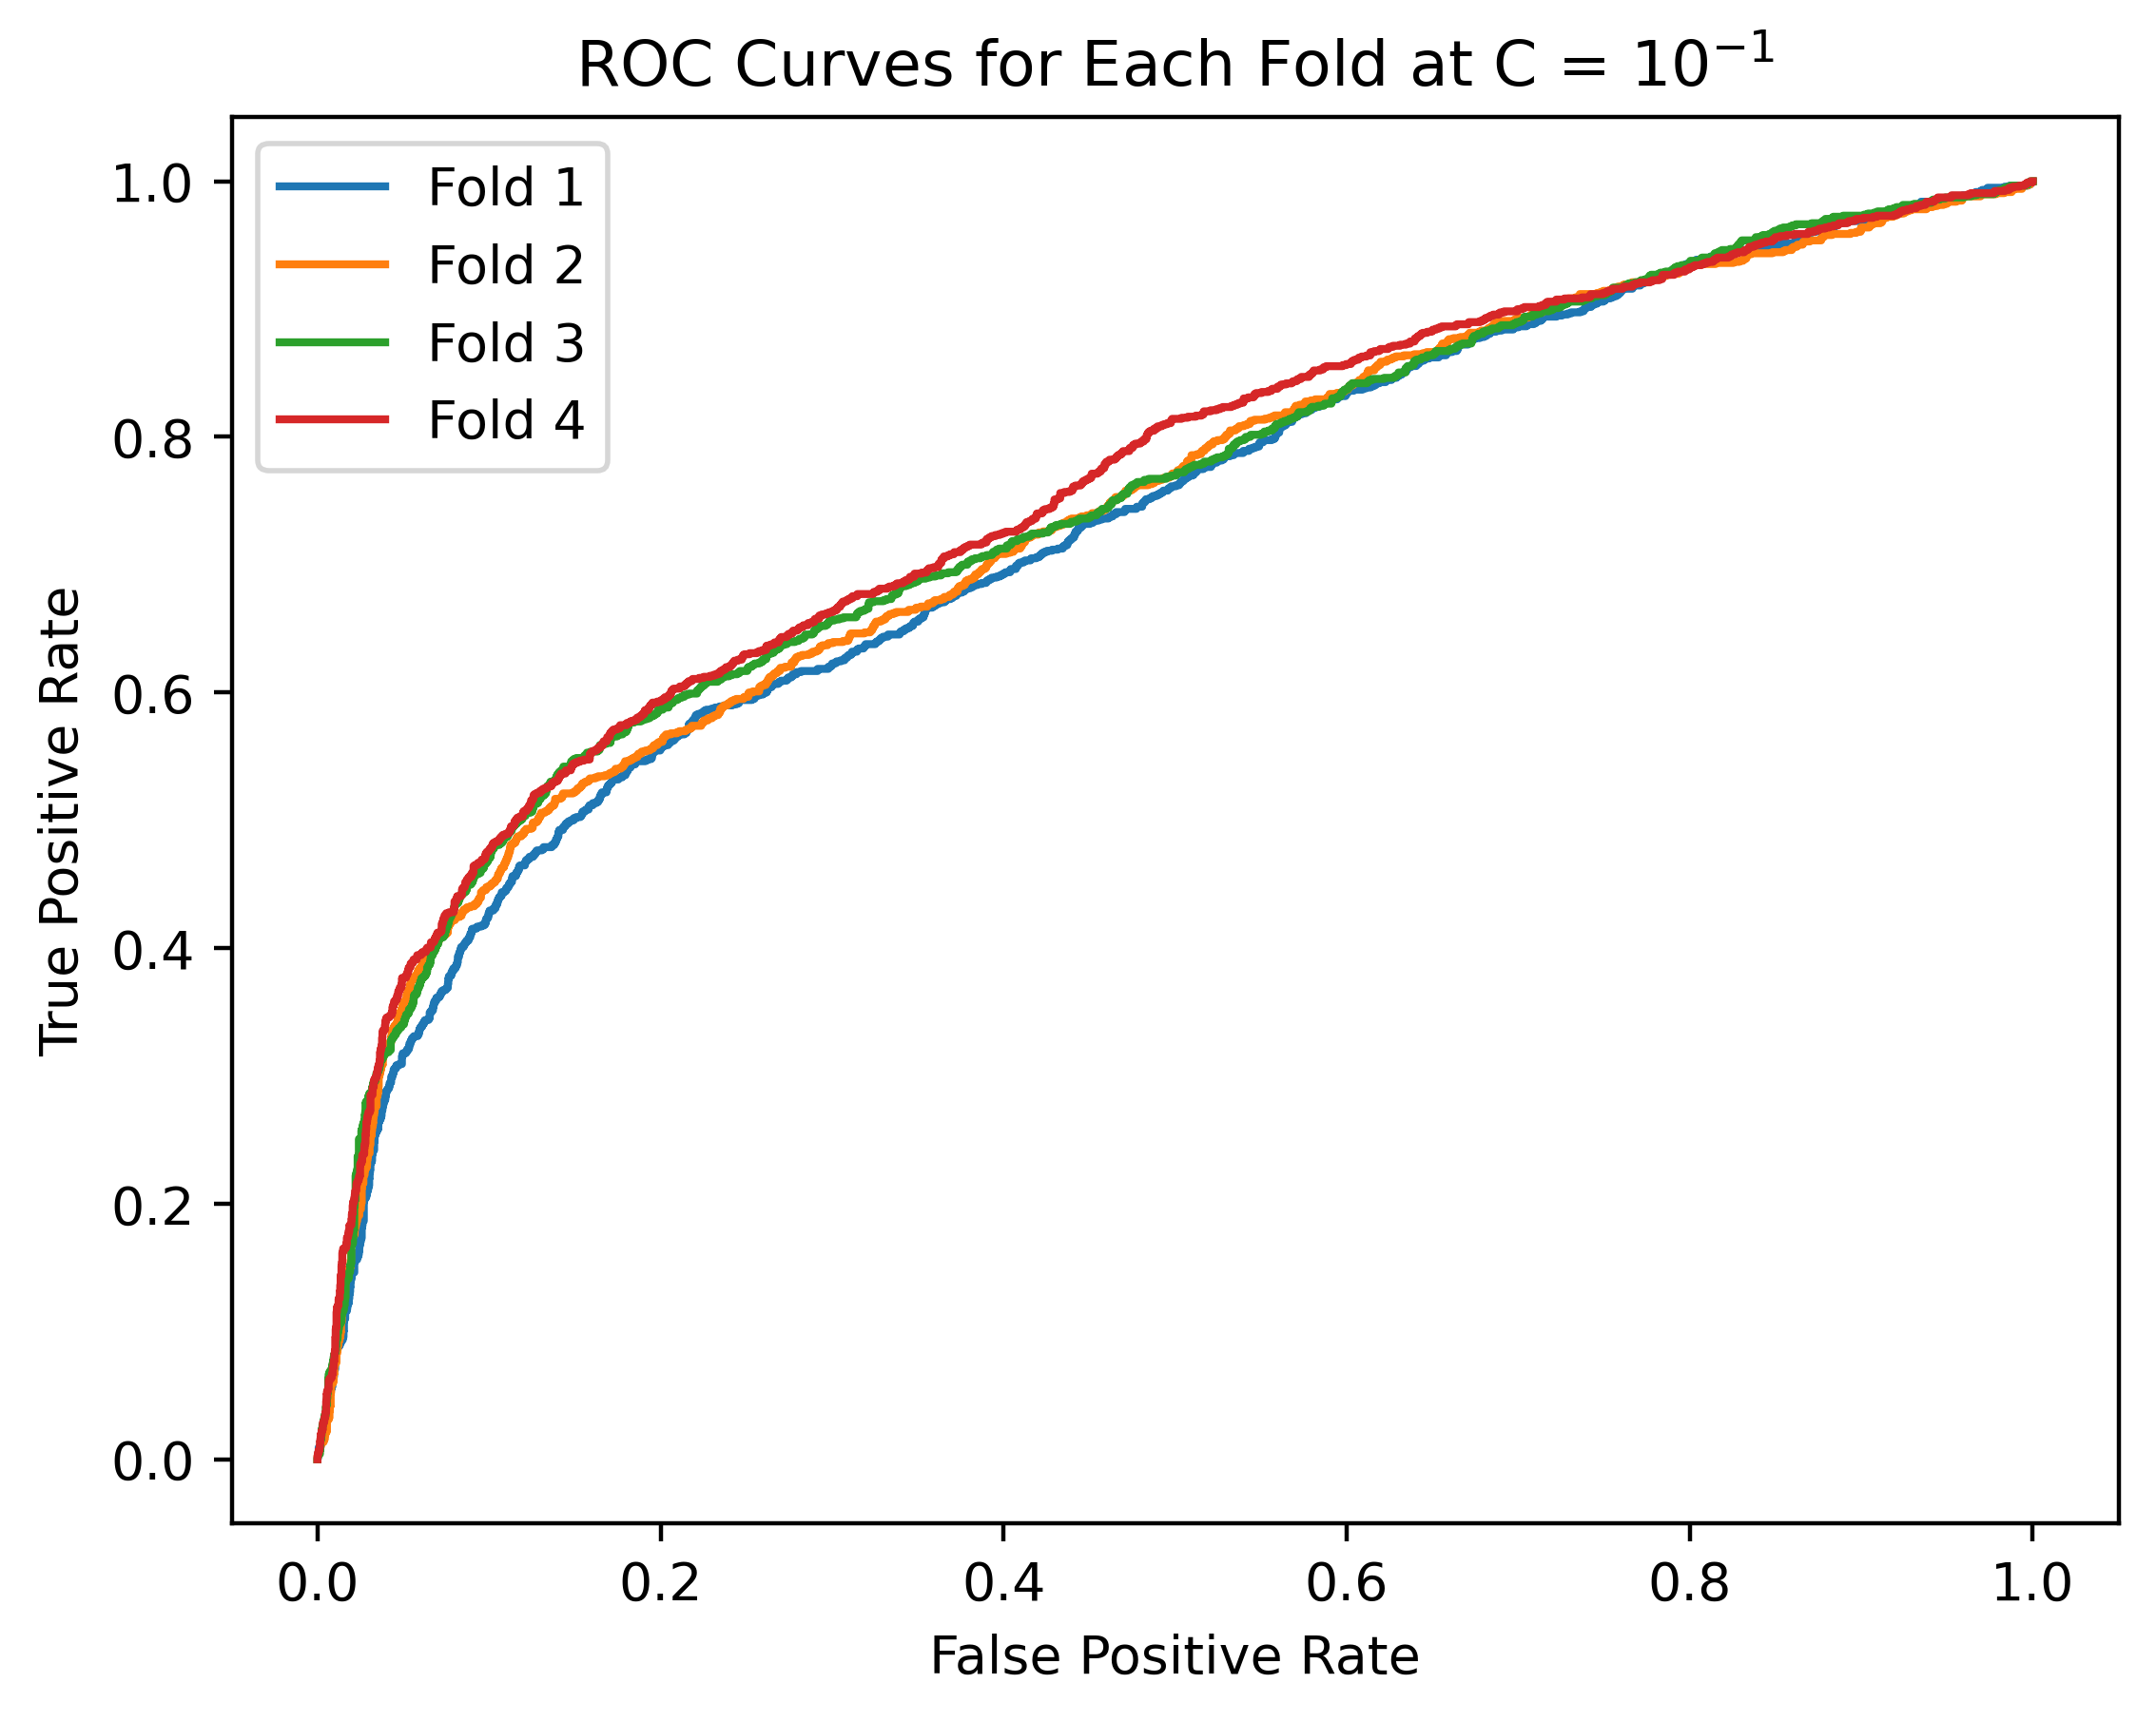

In [56]:
for fold in range(k_folds.n_splits):
    fpr = cv_test_roc[best_c_val_ix[0][0]][fold][0]
    tpr = cv_test_roc[best_c_val_ix[0][0]][fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(fold+1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold at C = $10^{-1}$')
plt.legend()
# From plot below, not too much variance between model 
# Normally, with desired FPR, pick a threshold from below.

# Exploration of Other Models - Decision Tree, Random Forest

# Decision Tree Exploration

In [57]:
# Exploring quick, simple decision tree. Will it perform better than logistic regression model?

In [58]:
dt = DecisionTreeClassifier(max_depth=2)

In [59]:
# Focusing just on max_depth of decision tree
params = {'max_depth': [1, 2, 4, 6, 8, 10, 12]}

In [60]:
cv = GridSearchCV(dt, param_grid=params, scoring='roc_auc', n_jobs=None, refit=True, cv=4, verbose=1, pre_dispatch=None, error_score=np.nan, return_train_score=True)

# refit=True lets estimator fit to the best parameter grid found

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df[features[:-1]].values, df[features[-1]].values, test_size=0.20, random_state=24)

In [62]:
cv.fit(X_train, y_train)
# 7 parameter values with 4 split cross validation, totaling 28 fits

Fitting 4 folds for each of 7 candidates, totalling 28 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_depth=2),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [63]:
cv_results_df = pd.DataFrame(cv.cv_results_)

In [64]:
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.016765,0.002497,0.001737,0.000444,1,{'max_depth': 1},0.639514,0.643398,0.651891,0.650753,0.646389,0.005136,7,0.648680,0.647384,0.644553,0.644934,0.646388,0.001712
1,0.028249,0.000434,0.001493,0.000493,2,{'max_depth': 2},0.695134,0.699022,0.713376,0.699510,0.701761,0.006917,5,0.704034,0.702700,0.698113,0.702535,0.701845,0.002232
2,0.051489,0.000511,0.001993,0.000014,4,{'max_depth': 4},0.732720,0.740116,0.746946,0.743731,0.740878,0.005294,2,0.756882,0.752256,0.749368,0.753055,0.752890,0.002682
3,0.075498,0.001500,0.002000,0.000017,6,{'max_depth': 6},0.744076,0.745784,0.750202,0.740748,0.745203,0.003408,1,0.782202,0.780125,0.775228,0.774776,0.778083,0.003171
4,0.096233,0.001075,0.002008,0.000012,8,{'max_depth': 8},0.729488,0.731050,0.750430,0.730316,0.735321,0.008741,3,0.811914,0.808353,0.803415,0.802004,0.806422,0.003951
5,0.125742,0.008278,0.002257,0.000429,10,{'max_depth': 10},0.708490,0.702281,0.719587,0.713669,0.711007,0.006387,4,0.848776,0.854304,0.841185,0.836474,0.845185,0.006854
6,0.139999,0.005520,0.002760,0.000435,12,{'max_depth': 12},0.674799,0.653570,0.672300,0.679856,0.670131,0.009942,6,0.888214,0.903660,0.885405,0.876229,0.888377,0.009875


In [65]:
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

Text(0.5, 1.0, 'Max Depth vs ROC AUC Train and Test Scores')

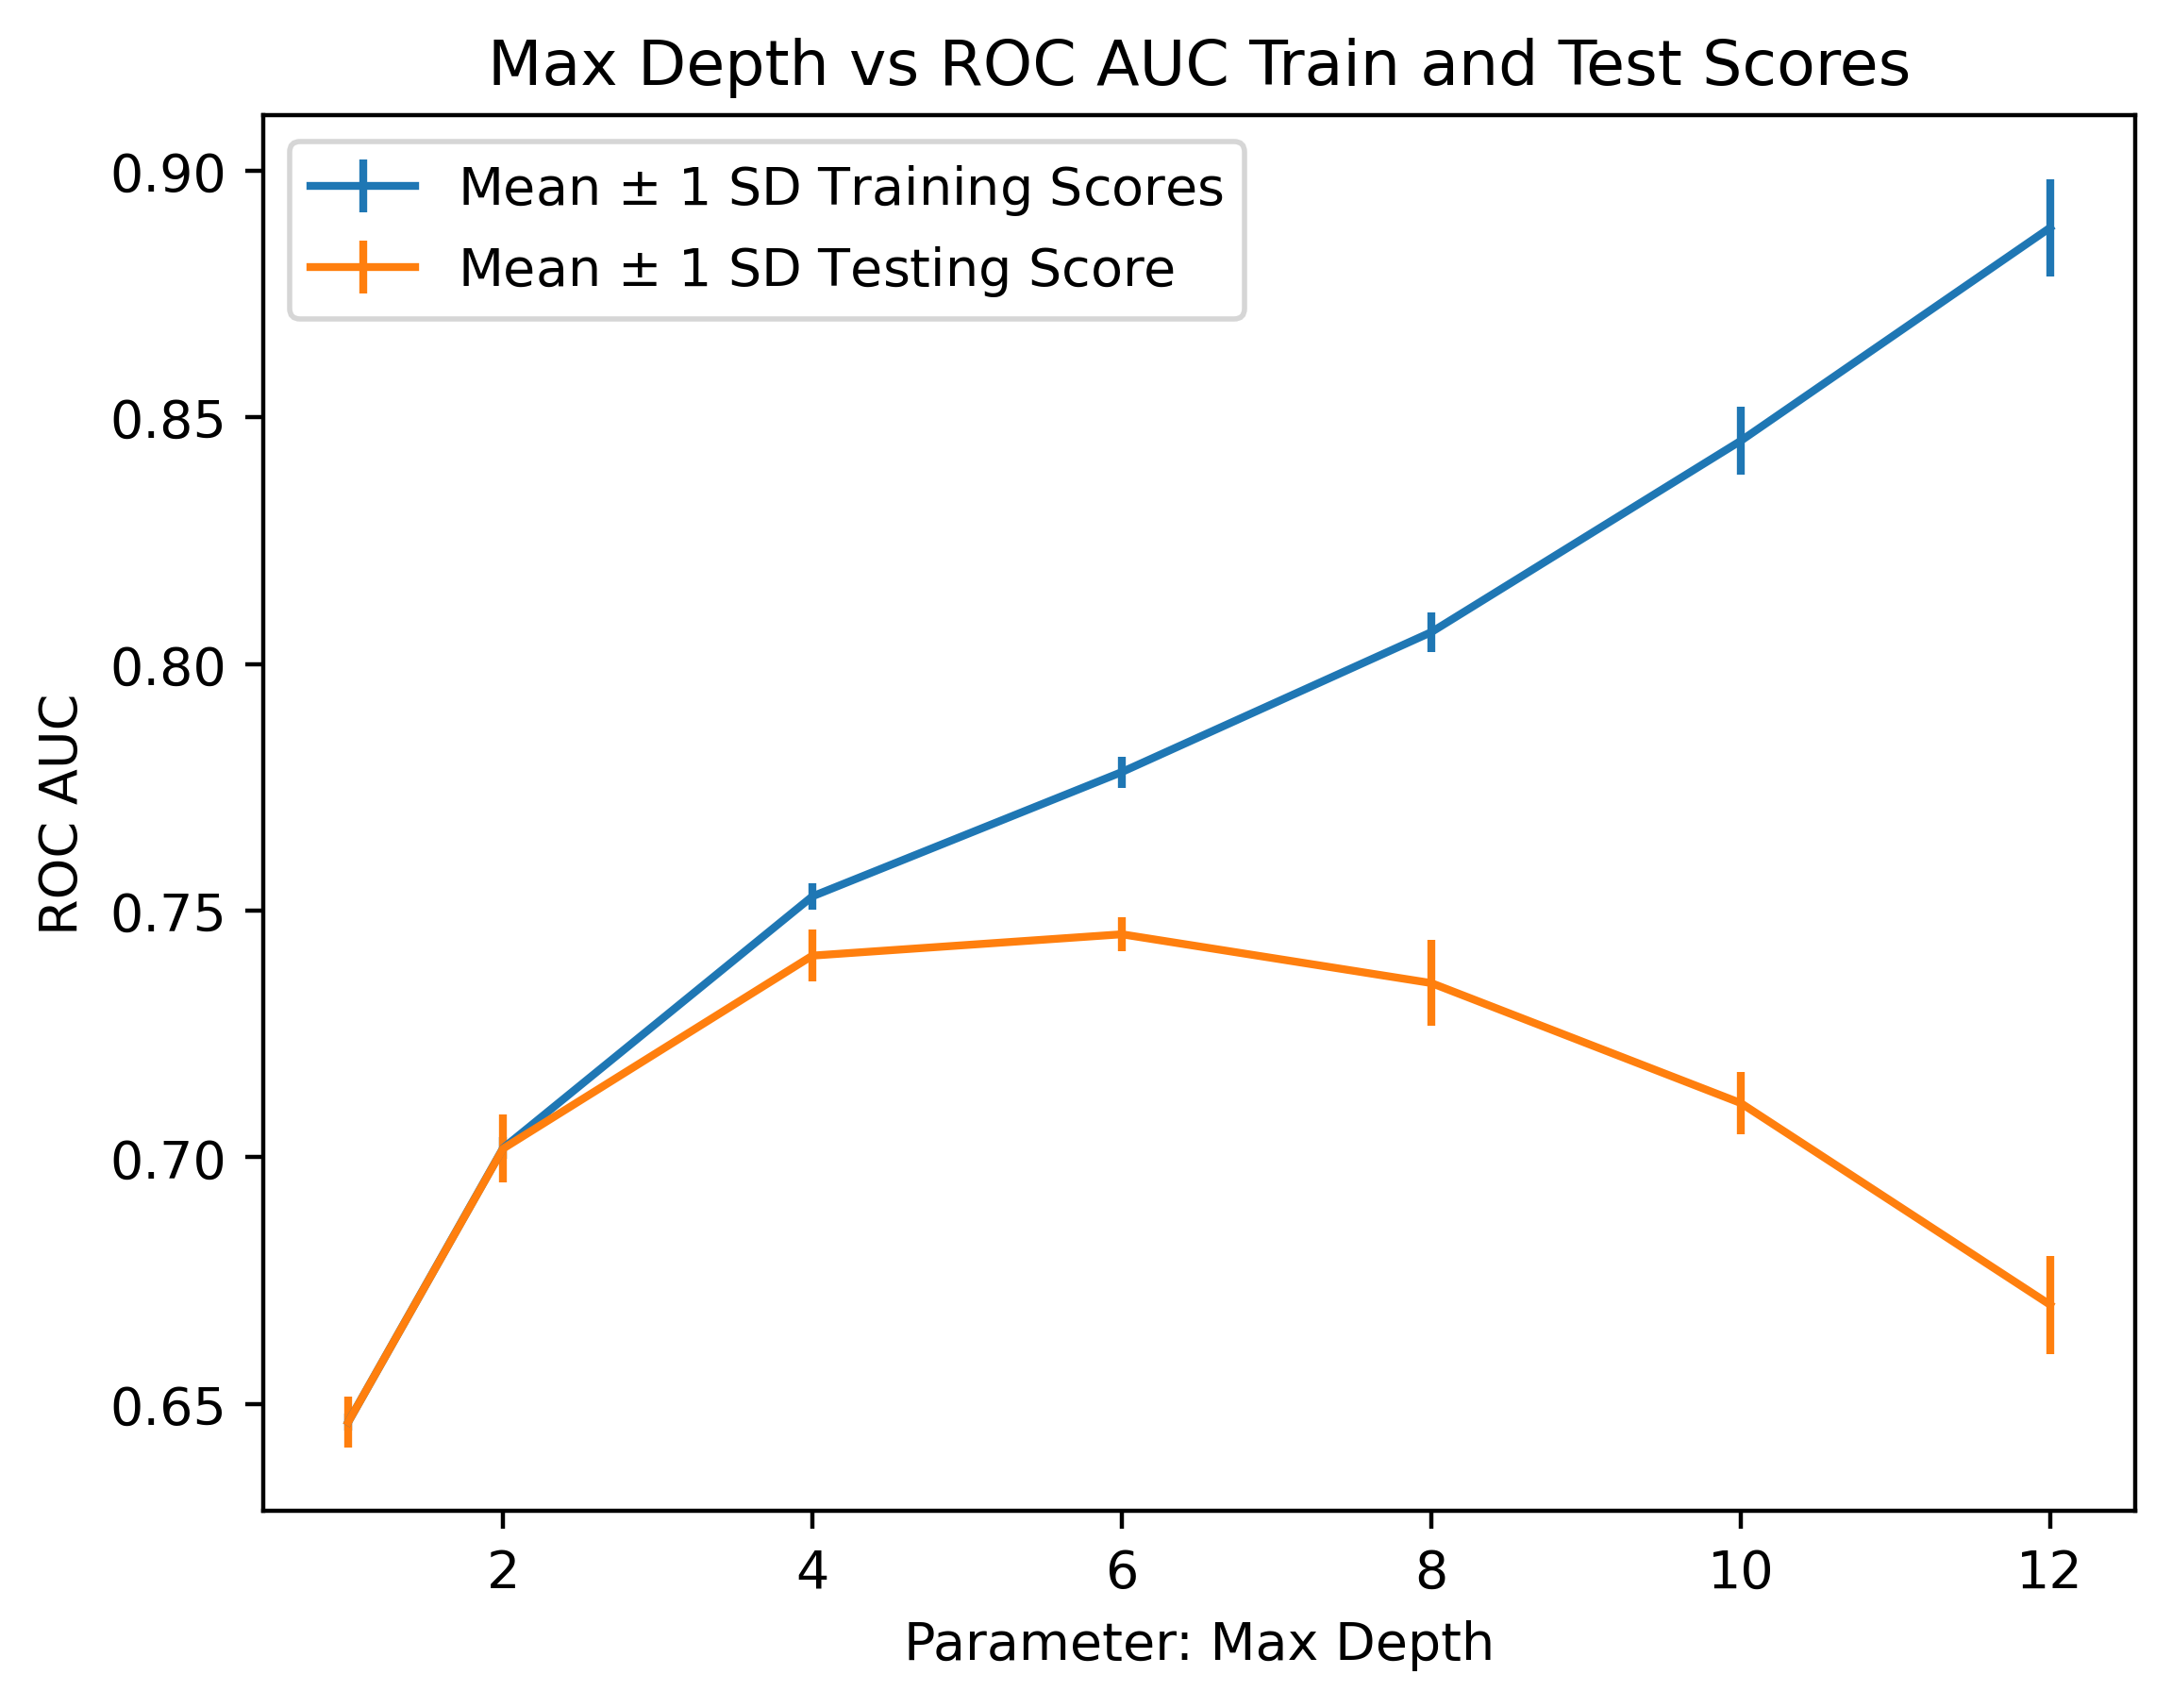

In [66]:
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'], cv_results_df['mean_train_score'], yerr=cv_results_df['std_train_score'], label='Mean $\pm$ 1 SD Training Scores')
ax.errorbar(cv_results_df['param_max_depth'], cv_results_df['mean_test_score'], yerr=cv_results_df['std_test_score'], label='Mean $\pm$ 1 SD Testing Score')
ax.legend()
plt.ylabel('ROC AUC')
plt.xlabel('Parameter: Max Depth')
plt.title('Max Depth vs ROC AUC Train and Test Scores')

# Plotting performance of model with varying max depths
# From plot below, overfitting occurs fairly early in maximum depths tested in this basic model. Greatest testing score occurs at a maximum depth of 6.
# As expected, decision trees tend to overfit quite easily (train score continues to increase and test score takes performance hit).


In [67]:
print('Max AUC ROC Score for DT: {} \nMax AUC ROC Score for Logistic Regression: {}'.format(max(cv_results_df['mean_test_score']), max(np.mean(cv_test_roc_auc, axis=0))))

# Despite its susceptibility to overfitting, DT's highest mean testing score still performs better than logistic regression

Max AUC ROC Score for DT: 0.7452027221596498 
Max AUC ROC Score for Logistic Regression: 0.7386904040944323


# Random Forest Exploration

To address model overfitting, exploring simple random forest model as comparison to DTs

In [68]:
rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=3,
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None,
random_state=4, verbose=0, warm_start=False, class_weight=None)

In [69]:
# Exploration of n_estimators and impact on scoring. RF uses randomized feature selection for splitting and bootstrap aggregation to ensure each weak learner model does not see the full dataset and also explores feature splits that otherwise would not have been explored as result of Decision Tree's basic greedy search method of splitting. Both approaches to modeling ideally produces a strong learner that does not suffer from the overfitting of a single DT.

rf_params_example = {
    'n_estimators': list(range(10, 110, 10))
}

In [70]:
cv_rf_example = GridSearchCV(rf, param_grid=rf_params_example, scoring='roc_auc', refit=True, error_score=np.nan, verbose=1, return_train_score=True)

In [71]:
cv_rf_example.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [72]:
cv_rf_results_example_df = pd.DataFrame(cv_rf_example.cv_results_)

In [73]:
cv_rf_results_example_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.097408,0.002933,0.004992,0.000895,10,{'n_estimators': 10},0.746594,0.745945,0.751689,0.771846,...,0.756495,0.010642,10,0.766549,0.764293,0.760630,0.757388,0.762718,0.762316,0.003134
1,0.171592,0.003004,0.006801,0.001167,20,{'n_estimators': 20},0.750097,0.753844,0.757607,0.778537,...,0.761175,0.010118,9,0.770423,0.768553,0.768020,0.762296,0.766355,0.767130,0.002743
2,0.249401,0.007301,0.009212,0.000410,30,{'n_estimators': 30},0.750020,0.756322,0.757938,0.778856,...,0.762143,0.010074,7,0.770647,0.769926,0.768661,0.763647,0.767516,0.768079,0.002462
3,0.349189,0.013551,0.011400,0.001019,40,{'n_estimators': 40},0.751988,0.753061,0.756997,0.780233,...,0.762040,0.010702,8,0.772219,0.769427,0.768748,0.764776,0.766744,0.768383,0.002515
4,0.408217,0.002143,0.013190,0.000741,50,{'n_estimators': 50},0.753248,0.755398,0.758032,0.782004,...,0.763233,0.010569,1,0.772938,0.770815,0.769056,0.765923,0.768058,0.769358,0.002388
5,0.489322,0.001261,0.015408,0.000484,60,{'n_estimators': 60},0.753124,0.755150,0.757815,0.781853,...,0.763114,0.010610,2,0.773053,0.770777,0.769538,0.765840,0.767653,0.769372,0.002489
6,0.576602,0.006683,0.017605,0.000482,70,{'n_estimators': 70},0.751764,0.754817,0.757305,0.781786,...,0.762595,0.010920,5,0.772080,0.770194,0.769232,0.765572,0.767207,0.768857,0.002273
7,0.643606,0.007507,0.020007,0.000012,80,{'n_estimators': 80},0.751515,0.754944,0.757293,0.782051,...,0.762691,0.011076,3,0.771858,0.769899,0.769374,0.765845,0.767727,0.768941,0.002034
8,0.712606,0.001759,0.021800,0.000401,90,{'n_estimators': 90},0.750878,0.754986,0.757039,0.781704,...,0.762284,0.011032,6,0.771431,0.769911,0.769181,0.765374,0.767289,0.768637,0.002107
9,0.793411,0.002577,0.024210,0.000748,100,{'n_estimators': 100},0.751308,0.755503,0.757298,0.782047,...,0.762674,0.011004,4,0.771874,0.770492,0.769539,0.765579,0.767667,0.769030,0.002203


Text(0.5, 1.0, 'Number of Trees vs Mean Test ROC AUC Score')

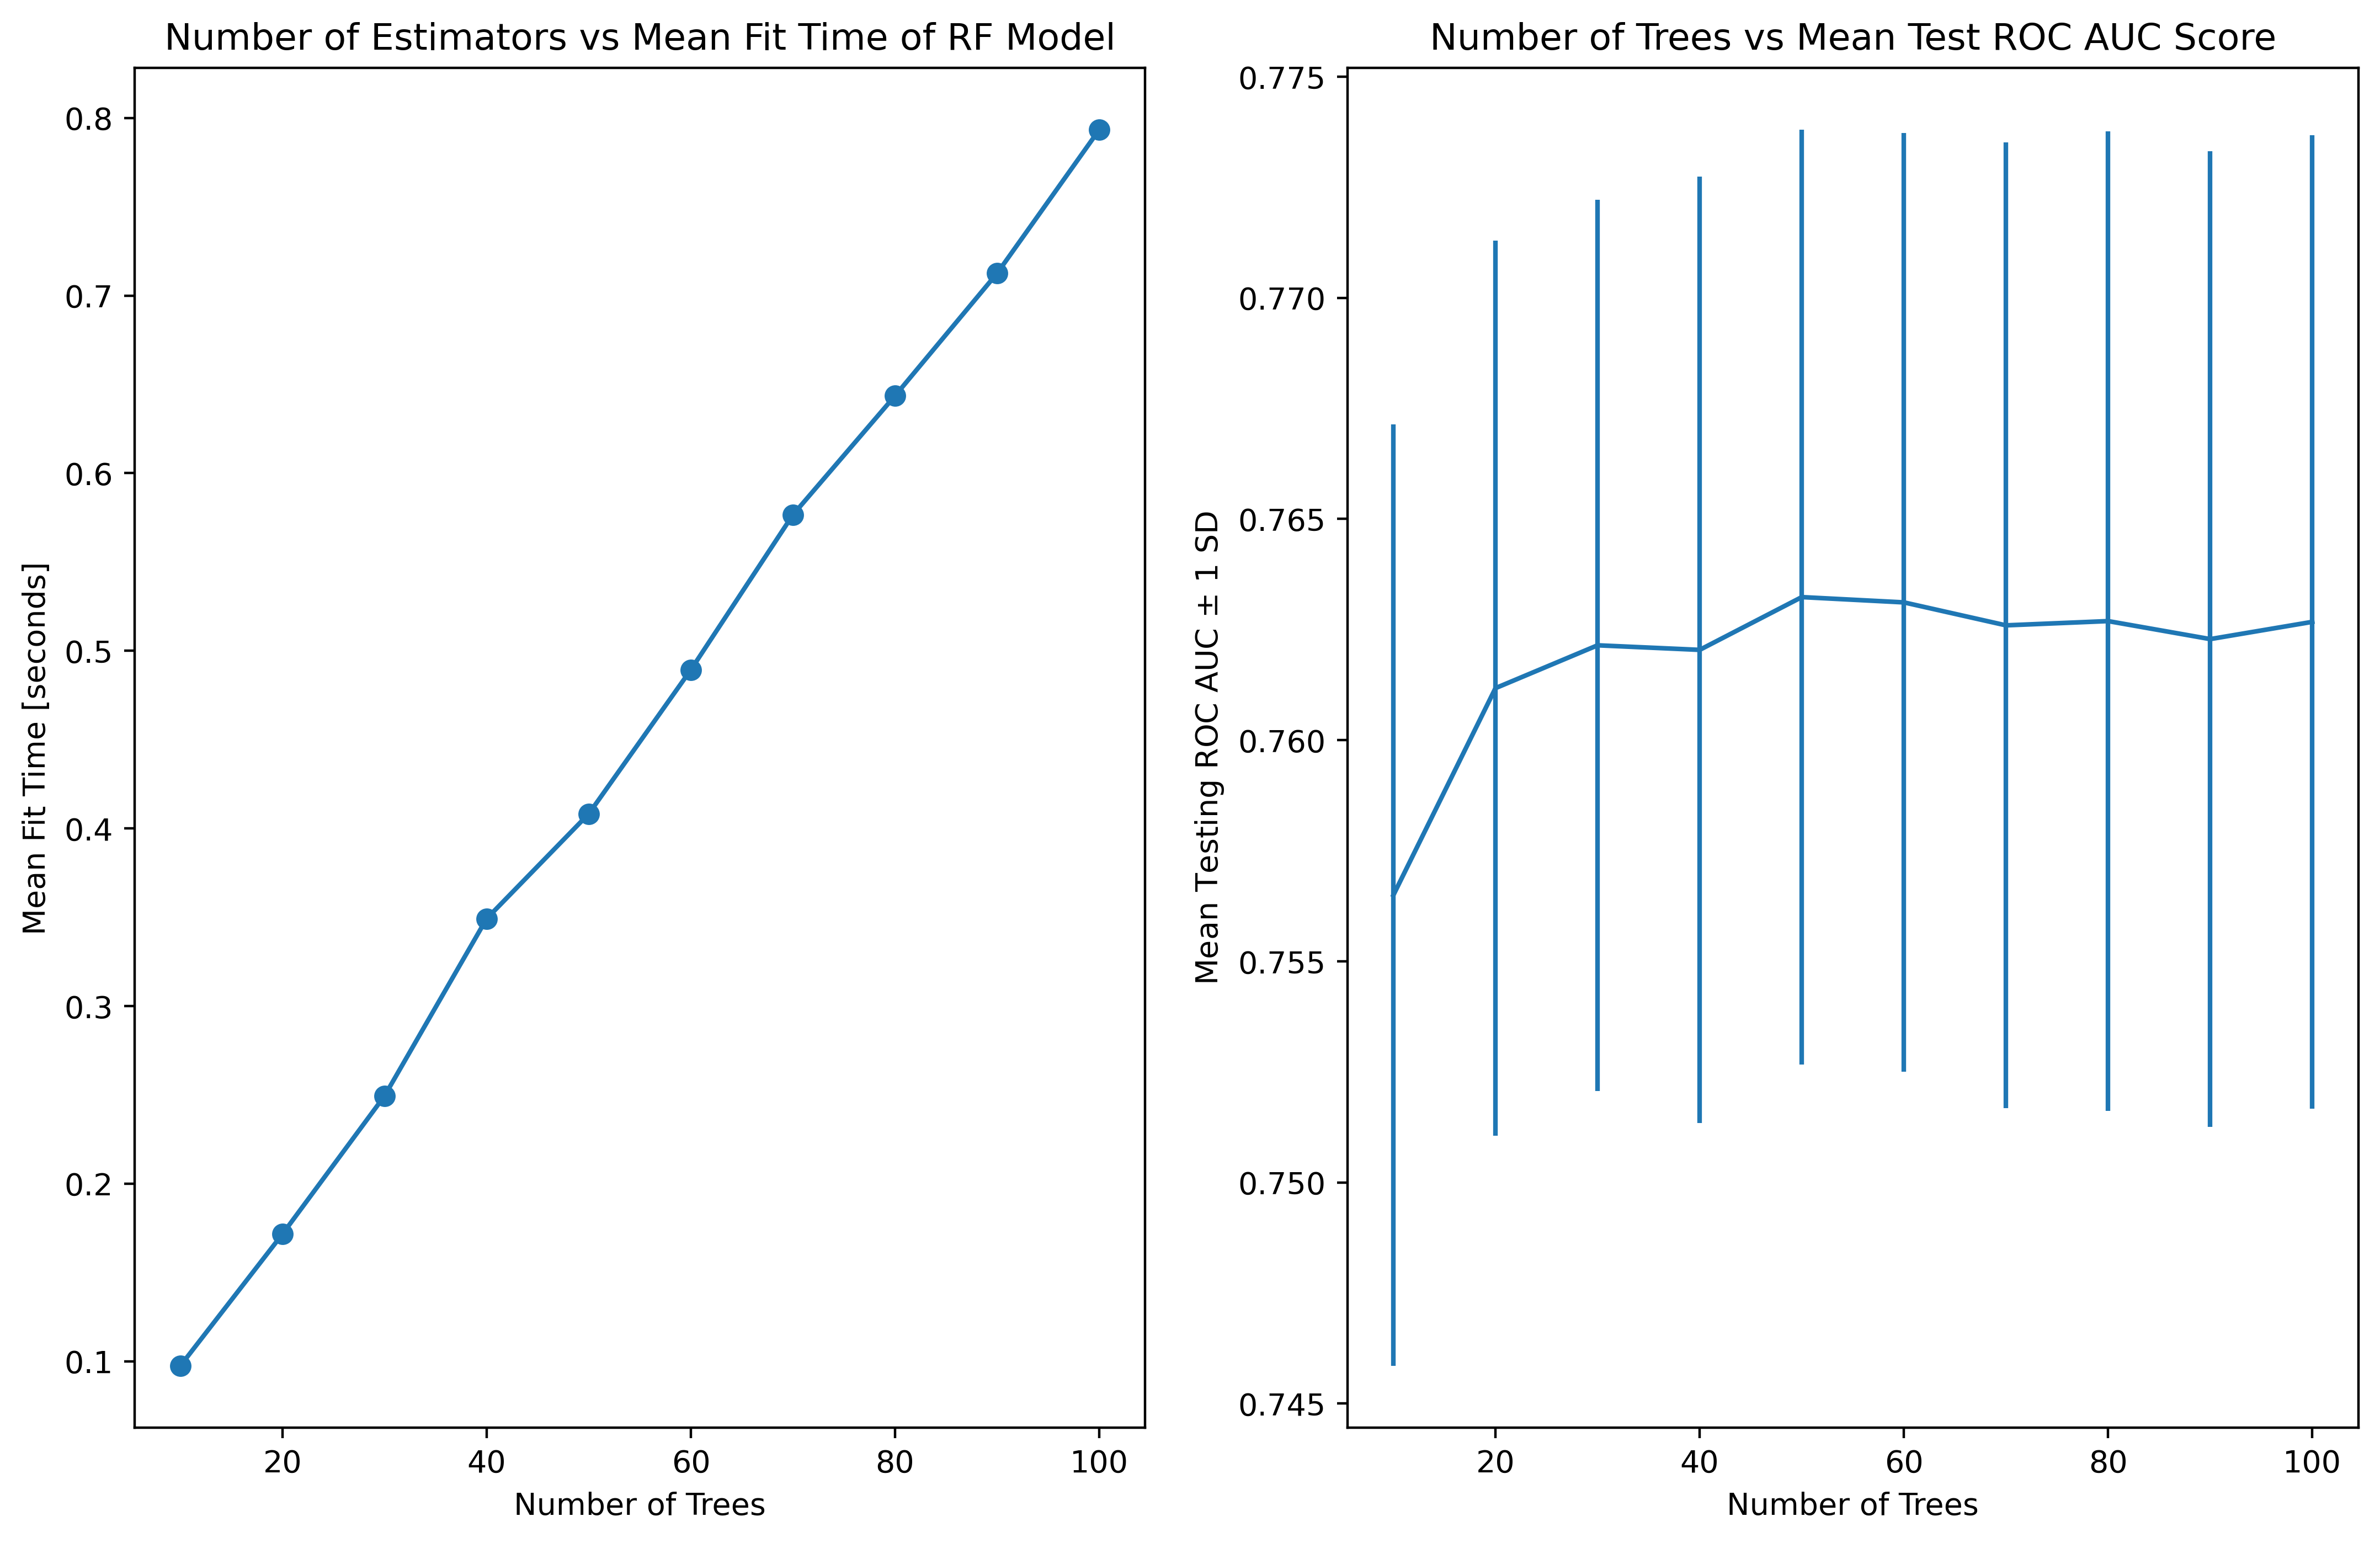

In [74]:
# In addition to plotting performance of rf example model with increasing n_estimators, time will also be plotted with respect to n_estimators
# This will provide an idea of if the resource consumption that comes along with larger n_estimators is worth the performance gain
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 8))

ax[0].plot(cv_rf_results_example_df['param_n_estimators'], cv_rf_results_example_df['mean_fit_time'], '-o')
ax[0].set_ylabel('Mean Fit Time [seconds]')
ax[0].set_xlabel('Number of Trees')
ax[0].set_title('Number of Estimators vs Mean Fit Time of RF Model')

ax[1].errorbar(cv_rf_results_example_df['param_n_estimators'], cv_rf_results_example_df['mean_test_score'], yerr=cv_rf_results_example_df['std_test_score'])
ax[1].set_ylabel('Mean Testing ROC AUC $\pm$ 1 SD')
ax[1].set_xlabel('Number of Trees')
ax[1].set_title('Number of Trees vs Mean Test ROC AUC Score')

# From plots below, ROC AUC scores have diminishing returns after a certain point. Once number of trees passes ~20 trees, the ROC AUC score seems to fluctuate up and down due to random chance at that point. Although the maximum testing score is at 50 estimators, the ROC AUC fluctuating from 30 estimators to 110 estimators may indicate that the increase in score past 20 or so estimators may be due to random chance. In combination with the fluctuation of ROC AUC scores, the mean fit time of the model increases linearly with increasing number of trees


In [75]:
cv_rf_example.best_estimator_

RandomForestClassifier(max_depth=3, n_estimators=50, random_state=4)

In [76]:
feat_imp_df = pd.DataFrame(
    {'Feature Importance': cv_rf_example.best_estimator_.feature_importances_},
    index=features[:-1])
feat_imp_df.sort_values(by='Feature Importance', ascending=False)
# Note that the top 5 ranked features by the best performing random forest model matches the 5 top ranked features by the ANOVA F-statistic earlier above in the notebook (not in the exact same order)


,Feature Importance
PAY_1,0.609609
PAY_AMT1,0.094123
LIMIT_BAL,0.079265
PAY_AMT3,0.047067
PAY_AMT2,0.035393
BILL_AMT2,0.022422
PAY_AMT4,0.021164
PAY_AMT5,0.015962
BILL_AMT6,0.014293
BILL_AMT4,0.013454


<AxesSubplot:>

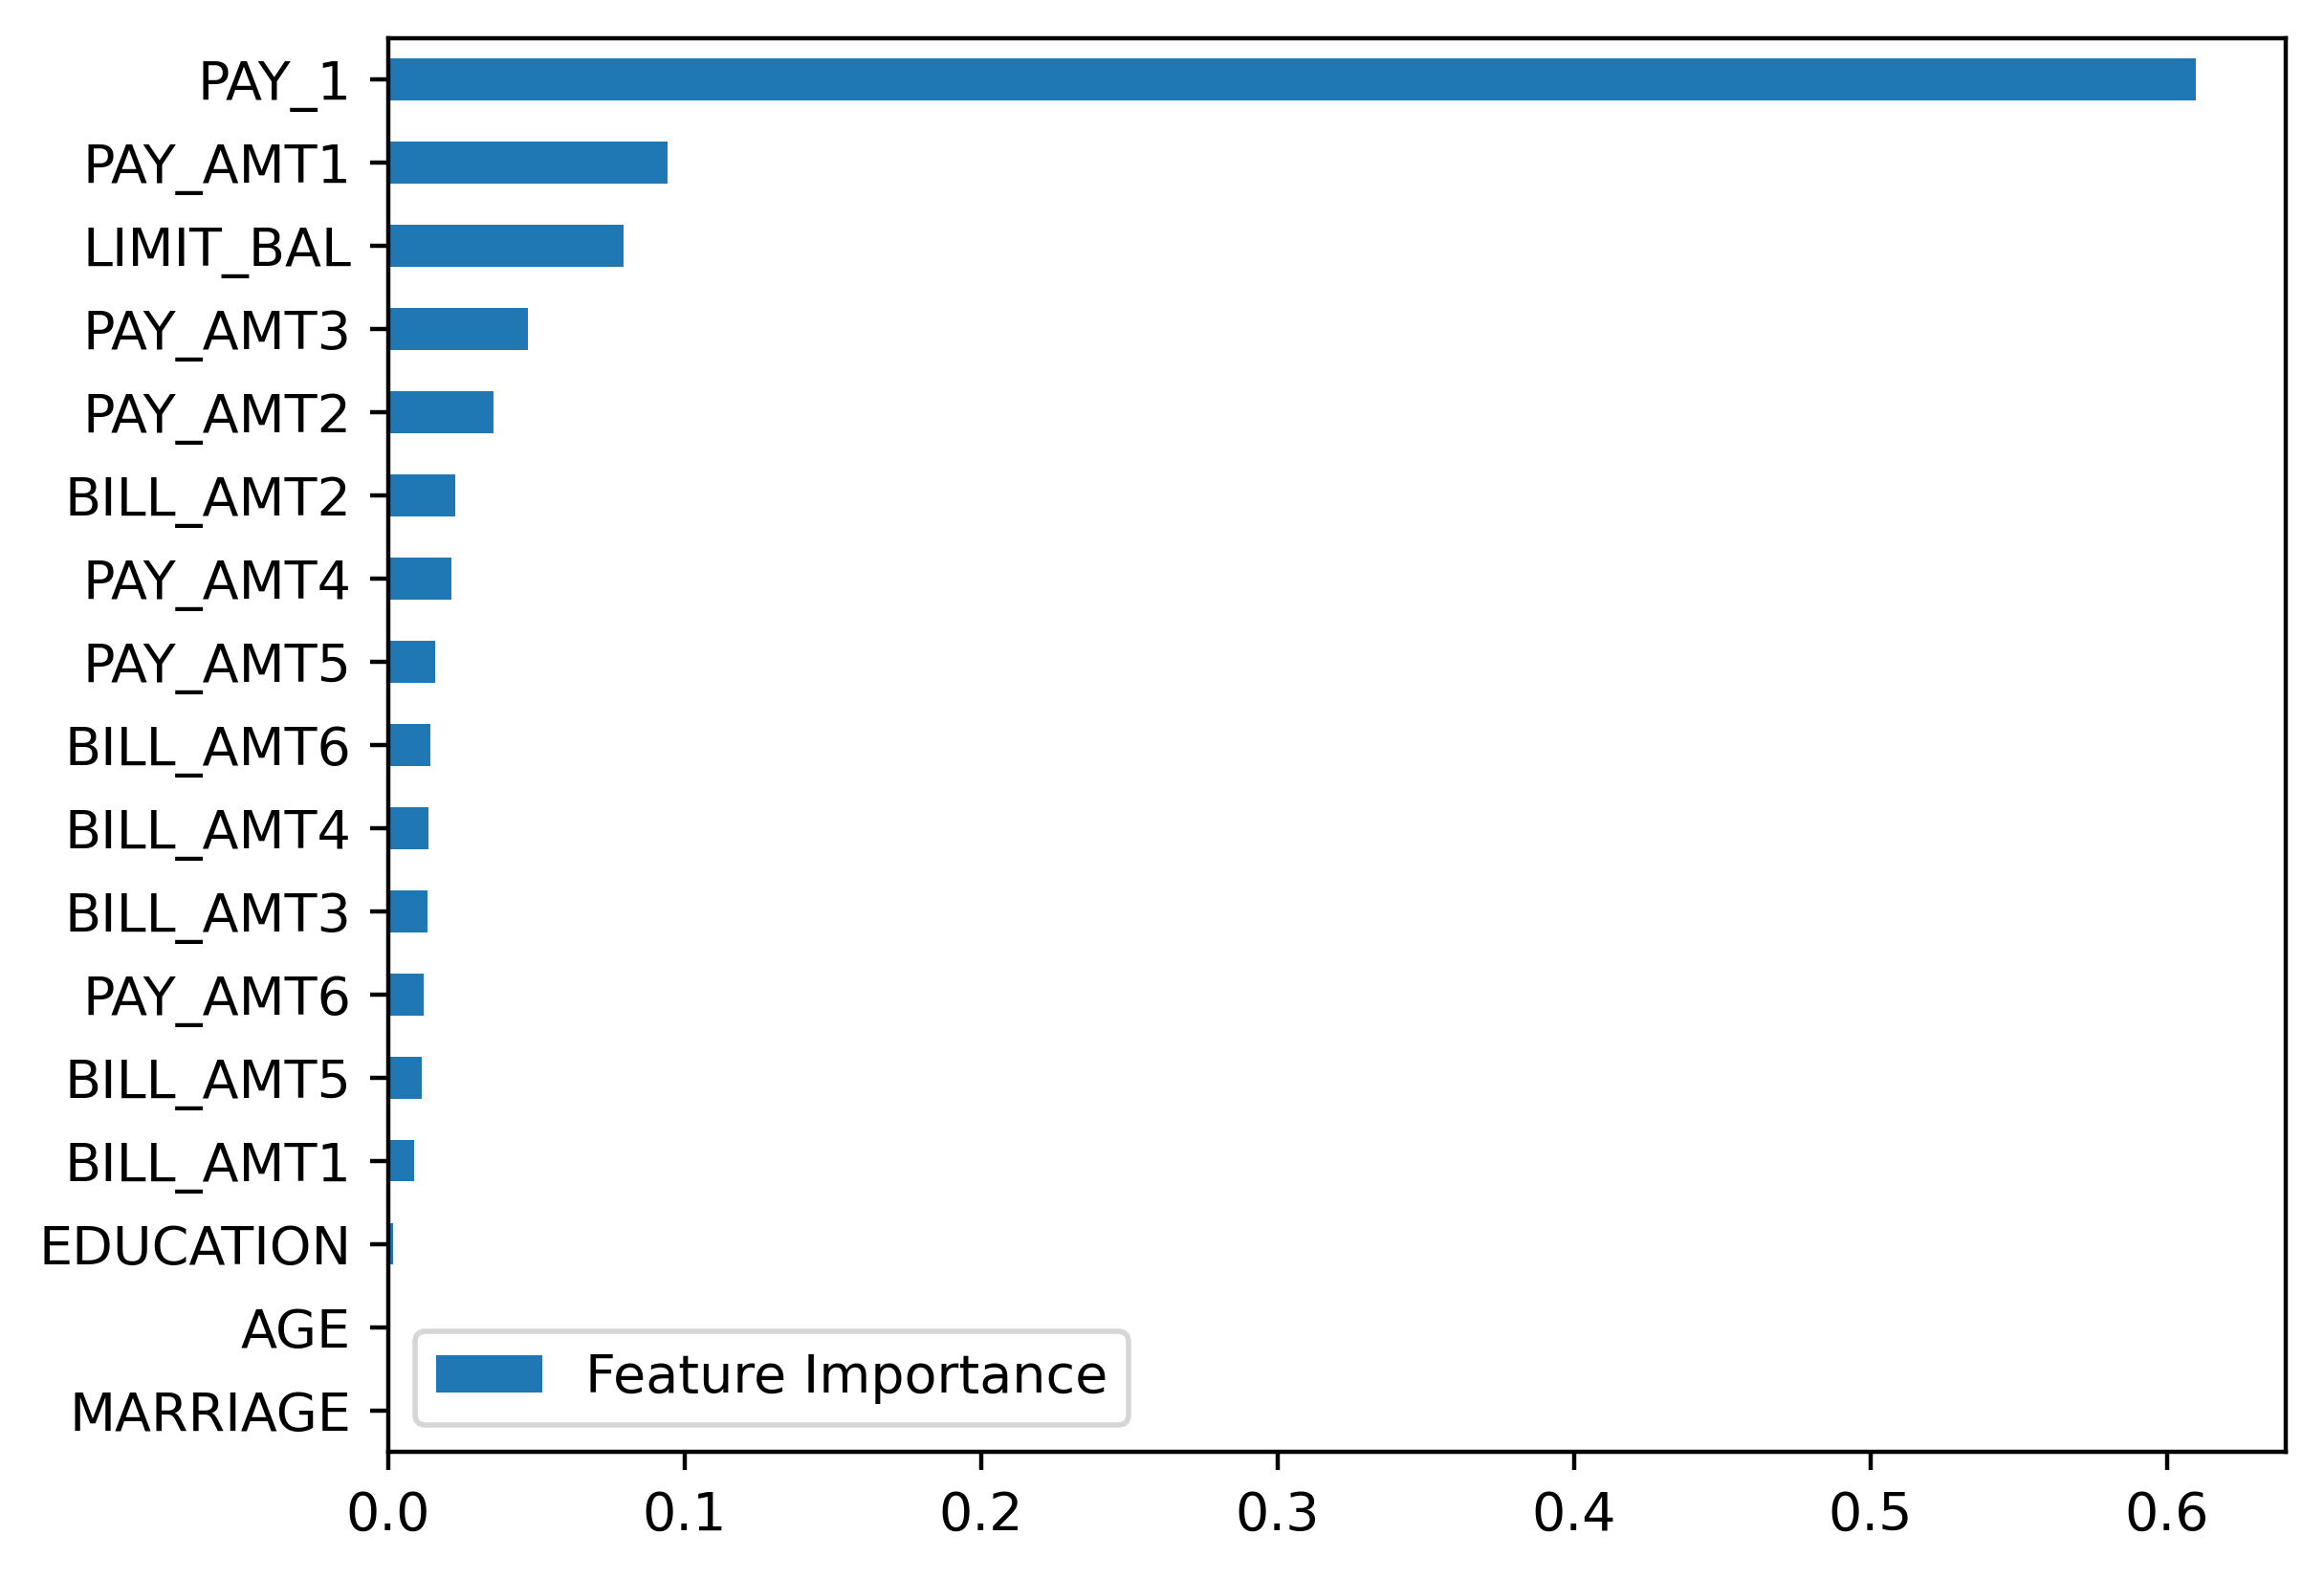

In [77]:
feat_imp_df.sort_values(by='Feature Importance', ascending=True).plot.barh()

Exploring both max_depth and n_estimators RF model

In [78]:
rf_params = {
    'max_depth': list(range(3, 15, 3)),
    'n_estimators': [10, 50, 100, 200]
}

In [79]:
cv_rf = GridSearchCV(rf, param_grid=rf_params, scoring='roc_auc', n_jobs=-1, refit=True, cv=4, verbose=2, error_score=np.nan, return_train_score=True)

In [80]:
cv_rf.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [81]:
cv_rf_results_df = pd.DataFrame(cv_rf.cv_results_)

In [82]:
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.016765,0.002497,0.001737,0.000444,1,{'max_depth': 1},0.639514,0.643398,0.651891,0.650753,0.646389,0.005136,7,0.648680,0.647384,0.644553,0.644934,0.646388,0.001712
1,0.028249,0.000434,0.001493,0.000493,2,{'max_depth': 2},0.695134,0.699022,0.713376,0.699510,0.701761,0.006917,5,0.704034,0.702700,0.698113,0.702535,0.701845,0.002232
2,0.051489,0.000511,0.001993,0.000014,4,{'max_depth': 4},0.732720,0.740116,0.746946,0.743731,0.740878,0.005294,2,0.756882,0.752256,0.749368,0.753055,0.752890,0.002682
3,0.075498,0.001500,0.002000,0.000017,6,{'max_depth': 6},0.744076,0.745784,0.750202,0.740748,0.745203,0.003408,1,0.782202,0.780125,0.775228,0.774776,0.778083,0.003171
4,0.096233,0.001075,0.002008,0.000012,8,{'max_depth': 8},0.729488,0.731050,0.750430,0.730316,0.735321,0.008741,3,0.811914,0.808353,0.803415,0.802004,0.806422,0.003951
5,0.125742,0.008278,0.002257,0.000429,10,{'max_depth': 10},0.708490,0.702281,0.719587,0.713669,0.711007,0.006387,4,0.848776,0.854304,0.841185,0.836474,0.845185,0.006854
6,0.139999,0.005520,0.002760,0.000435,12,{'max_depth': 12},0.674799,0.653570,0.672300,0.679856,0.670131,0.009942,6,0.888214,0.903660,0.885405,0.876229,0.888377,0.009875


In [83]:
# Trying a different presentation this time
# Checkerboard graph, with both parameters represented on a respective axis and a color bar to represent the score. Color bar acts as a z-axis for performance
xx_rf, yy_rf = np.meshgrid(range(5), range(5))  # Produces meshgrid of specified size
cm_rf = plt.cm.jet  # Grabbing jet rainbow color

In [84]:
xx_rf

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [85]:
yy_rf

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]])

Text(0, 0.5, 'Maximum depth')

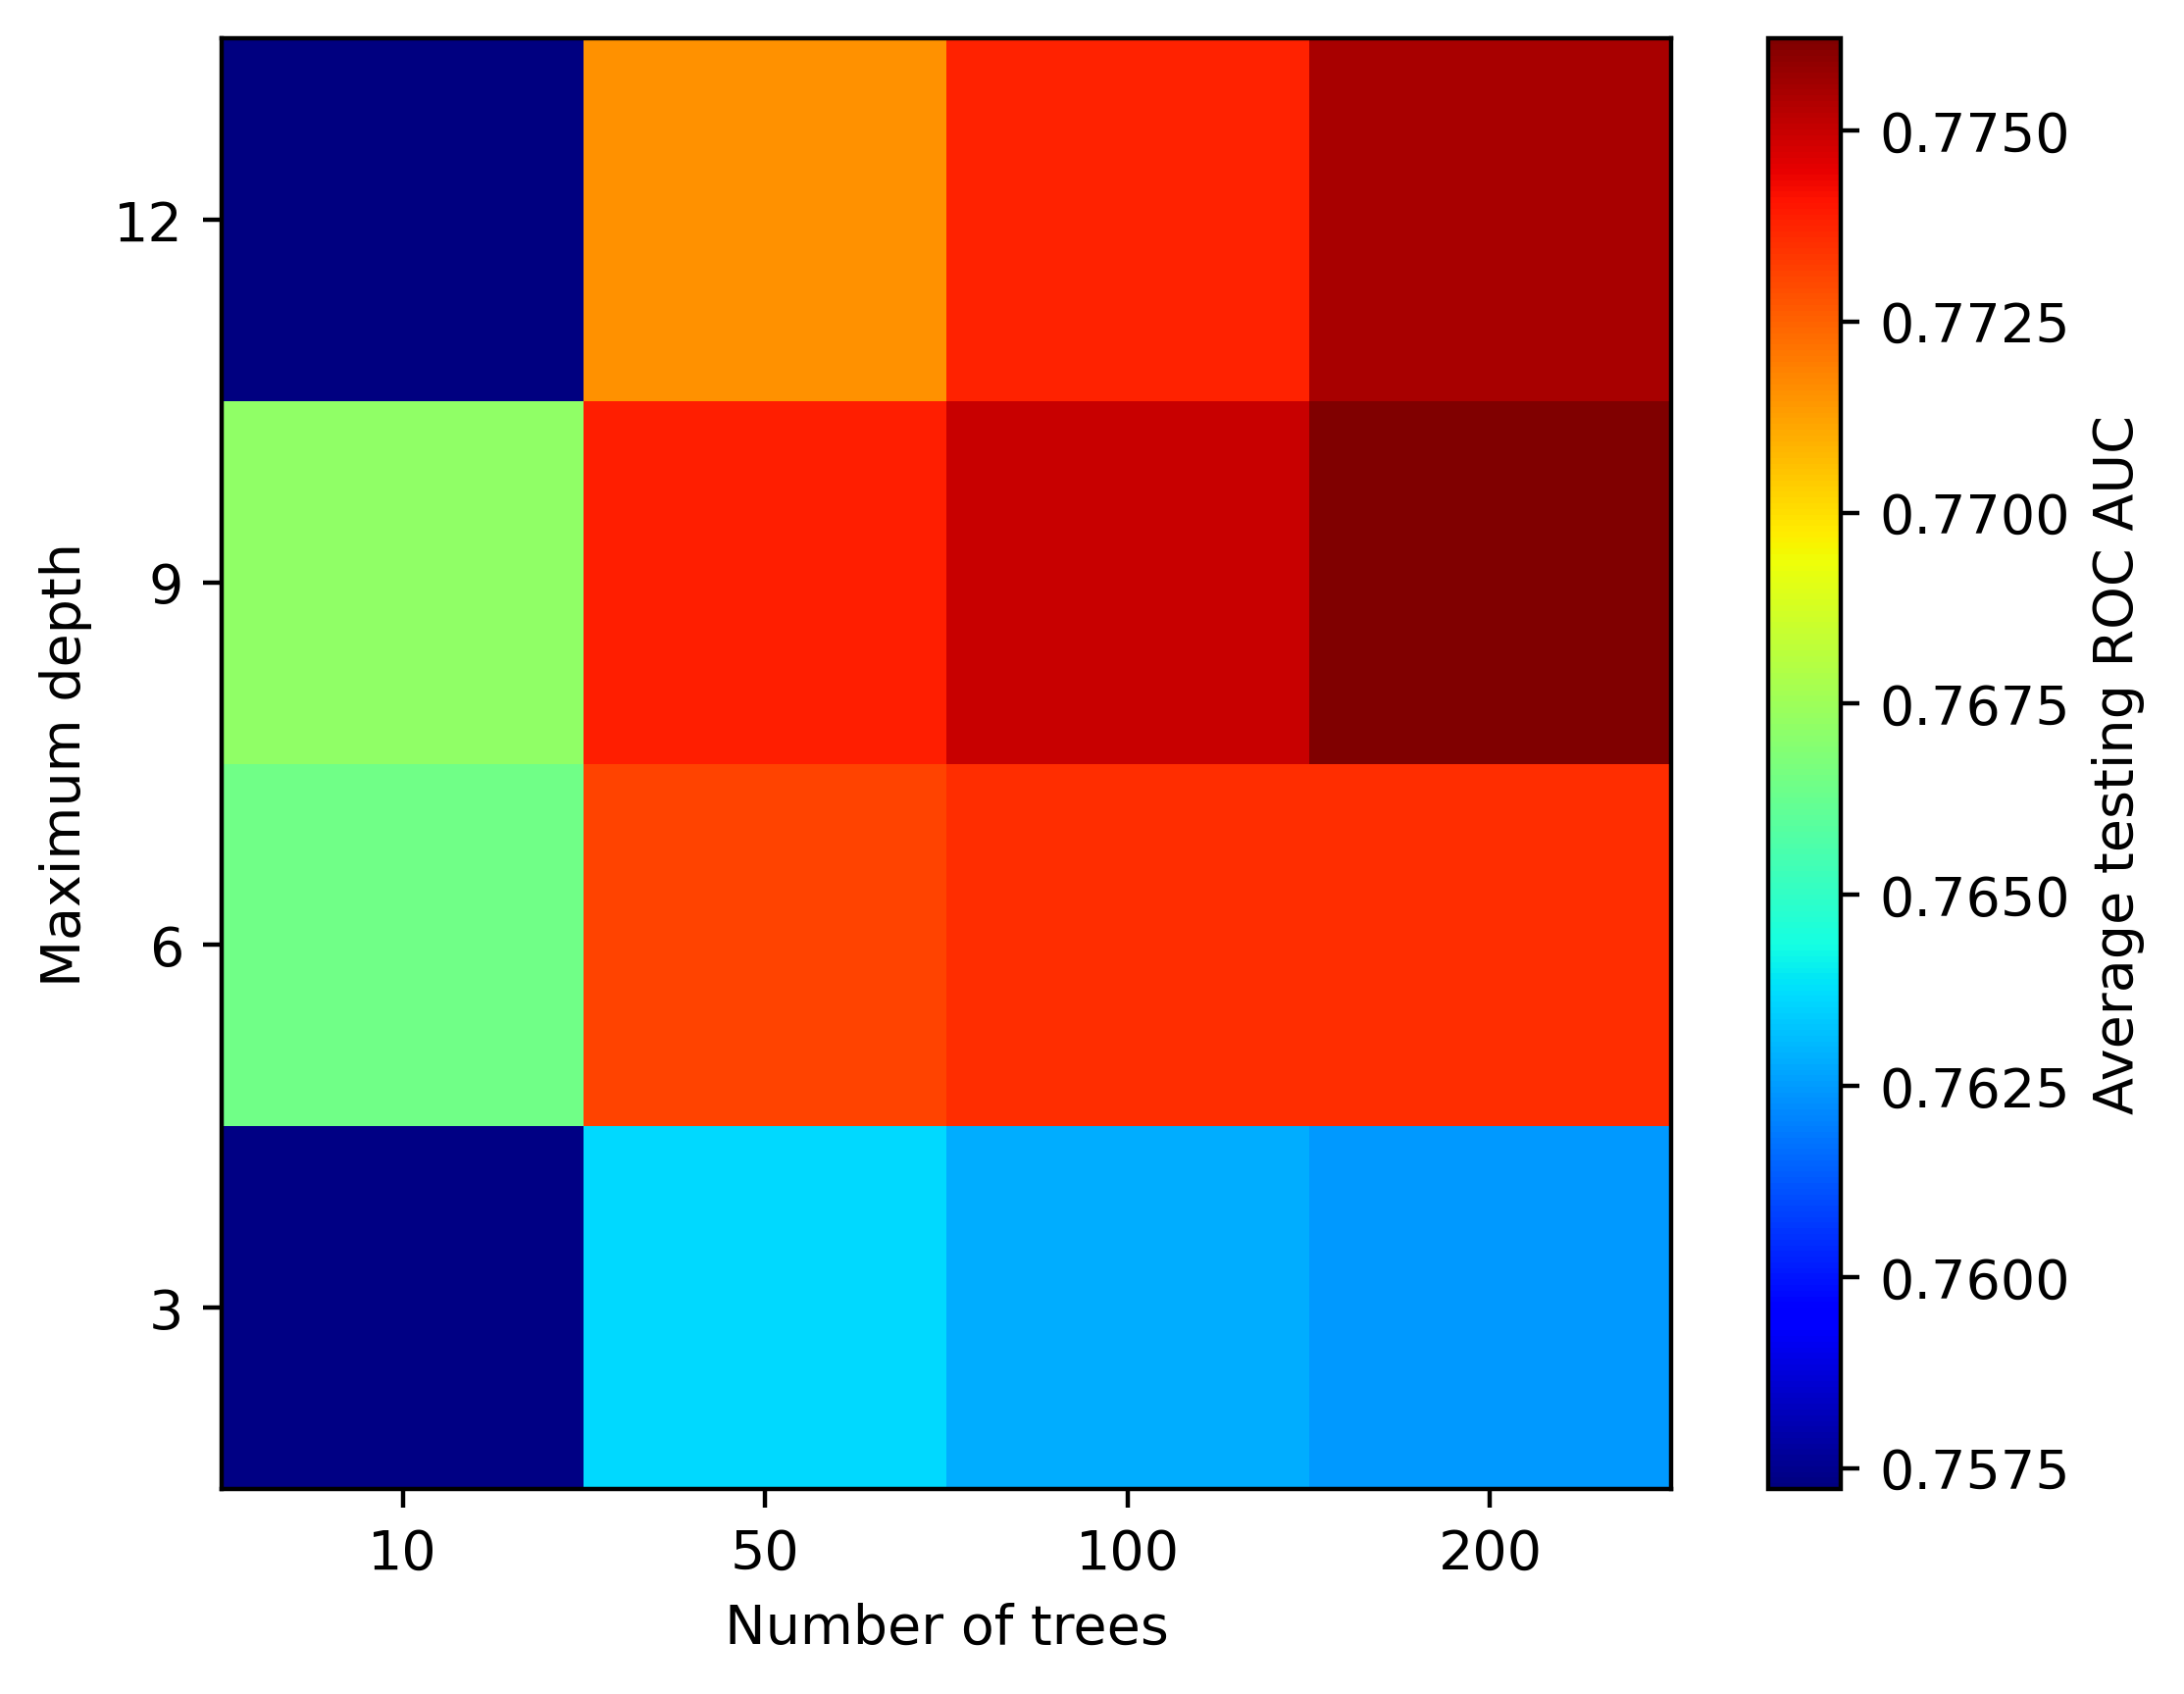

In [86]:
ax_rf = plt.axes()
pcolor_graph = ax_rf.pcolormesh(xx_rf, yy_rf, cv_rf_results_df['mean_test_score'].values.reshape((4,4)), cmap=cm_rf)
plt.colorbar(pcolor_graph, label='Average testing ROC AUC')
ax_rf.set_aspect('equal')
ax_rf.set_xticks([0.5, 1.5, 2.5, 3.5])
ax_rf.set_yticks([0.5, 1.5, 2.5, 3.5])
ax_rf.set_xticklabels([str(tick_label) for tick_label in rf_params['n_estimators']])
ax_rf.set_yticklabels([str(tick_label) for tick_label in rf_params['max_depth']])
ax_rf.set_xlabel('Number of trees')
ax_rf.set_ylabel('Maximum depth')

# From plot below, maximum depth of 9 with 200 trees produced the highest testing ROC AUC score

In [87]:
cv_rf.best_params_

{'max_depth': 9, 'n_estimators': 200}

In [88]:
cv_rf.best_score_
# Higher than DT and a base RF with only varying n_estimators

0.7761985118393935

In [89]:
feat_imp_df_actual = pd.DataFrame(
    {
        'Feature Importance': cv_rf.best_estimator_.feature_importances_
    },
    index=features[:-1]
)

In [90]:
feat_imp_df_actual.sort_values(by='Feature Importance', ascending=False)

,Feature Importance
PAY_1,0.437439
LIMIT_BAL,0.059961
PAY_AMT1,0.059434
PAY_AMT2,0.045518
PAY_AMT3,0.043299
BILL_AMT1,0.042195
BILL_AMT2,0.041562
BILL_AMT3,0.037268
PAY_AMT4,0.034321
BILL_AMT4,0.034123


In [91]:
# Updating random forest model with best performing hyperparameters
rf.set_params(**{'max_depth': 9, 'n_estimators': 200})

RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4)

# Model Performance on Test Set

In [92]:
rf.fit(X_train, y_train)
test_set_pred_proba = rf.predict_proba(X_test)[:, 1]

In [93]:
test_auc = roc_auc_score(y_test, test_set_pred_proba)
test_auc
# Overall test set performance is slightly worse than validation scores, but well within range. Difference in 0.002 ROC AUC

0.7745973031277005

# Financial Insights and Visualizations for Client Understanding

Text(0, 0.5, 'Number of Samples')

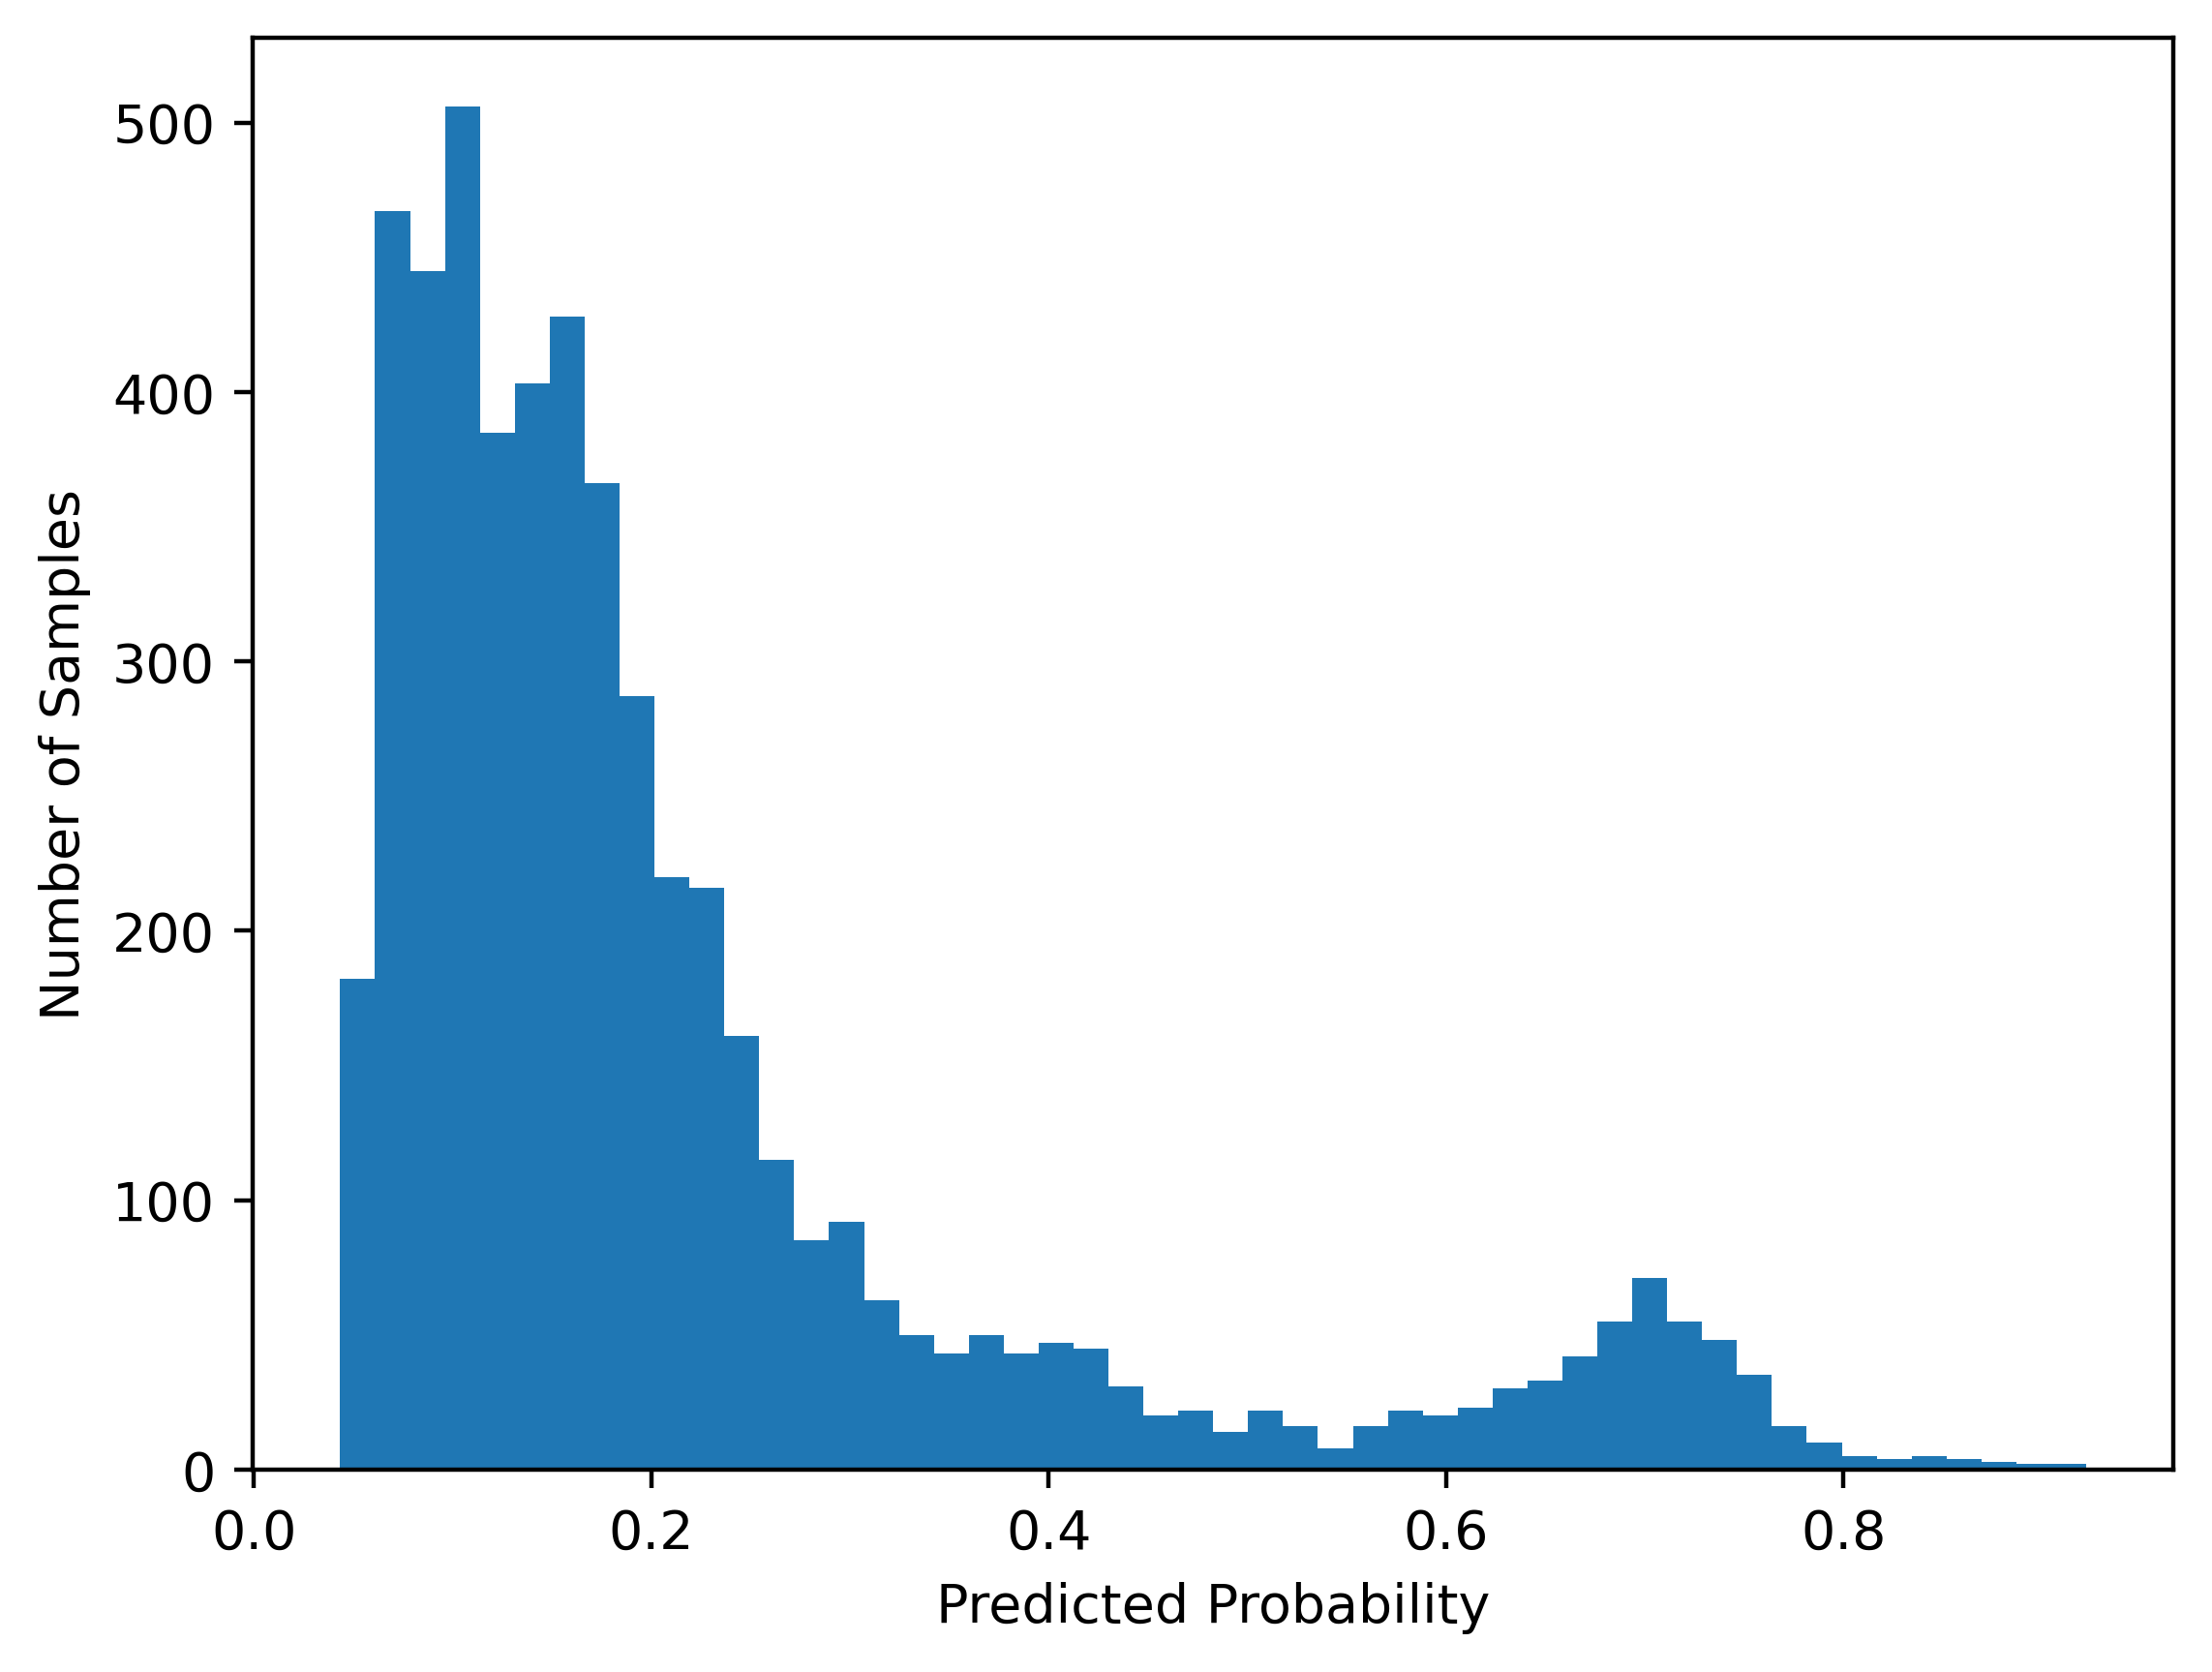

In [94]:
plt.hist(test_set_pred_proba, bins=50)
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Samples')
# From probability histogram, most of the population of accounts has a probability of defaulting from 0 to 0.20. 
# There is also a slight bump in counts of defaults for accounts with predicted probabilities ~0.70.

In [95]:
# Creating prediction probability deciles along with mean default rate by decile 
# Helps validate that our model is performing properly. Theoretically, samples predicted as defaulting and binned into higher probabilities will reflectively have higher true default rates in test data
deciles, decile_bin_edges = pd.qcut(x=test_set_pred_proba, q=10, retbins=True)
test_set_df = pd.DataFrame(
    {
        'Predicted Probability': test_set_pred_proba,
        'Prediction Decile': deciles,
        'True Classification': y_test
    }
)
test_set_df

,Predicted Probability,Prediction Decile,True Classification
0,0.497302,"(0.289, 0.512]",0
1,0.500612,"(0.289, 0.512]",0
2,0.074891,"(0.0424, 0.0751]",0
3,0.890613,"(0.512, 0.922]",1
4,0.268906,"(0.222, 0.289]",0
...,...,...,...
5328,0.128240,"(0.114, 0.138]",0
5329,0.149154,"(0.138, 0.159]",0
5330,0.100040,"(0.0953, 0.114]",0
5331,0.381621,"(0.289, 0.512]",0


In [97]:
test_set_gr = test_set_df.groupby(by='Prediction Decile').agg({'True Classification': ['count', 'mean']})
test_set_gr
# Multi index DF, count of accounts classified in each decile range and mean default rate 

True Classification          
                                count      mean
Prediction Decile                              
(0.0424, 0.0751]                  534  0.043071
(0.0751, 0.0953]                  533  0.056285
(0.0953, 0.114]                   533  0.108818
(0.114, 0.138]                    533  0.125704
(0.138, 0.159]                    534  0.140449
(0.159, 0.185]                    533  0.146341
(0.185, 0.222]                    533  0.189493
(0.222, 0.289]                    533  0.262664
(0.289, 0.512]                    533  0.409006
(0.512, 0.922]                    534  0.683521

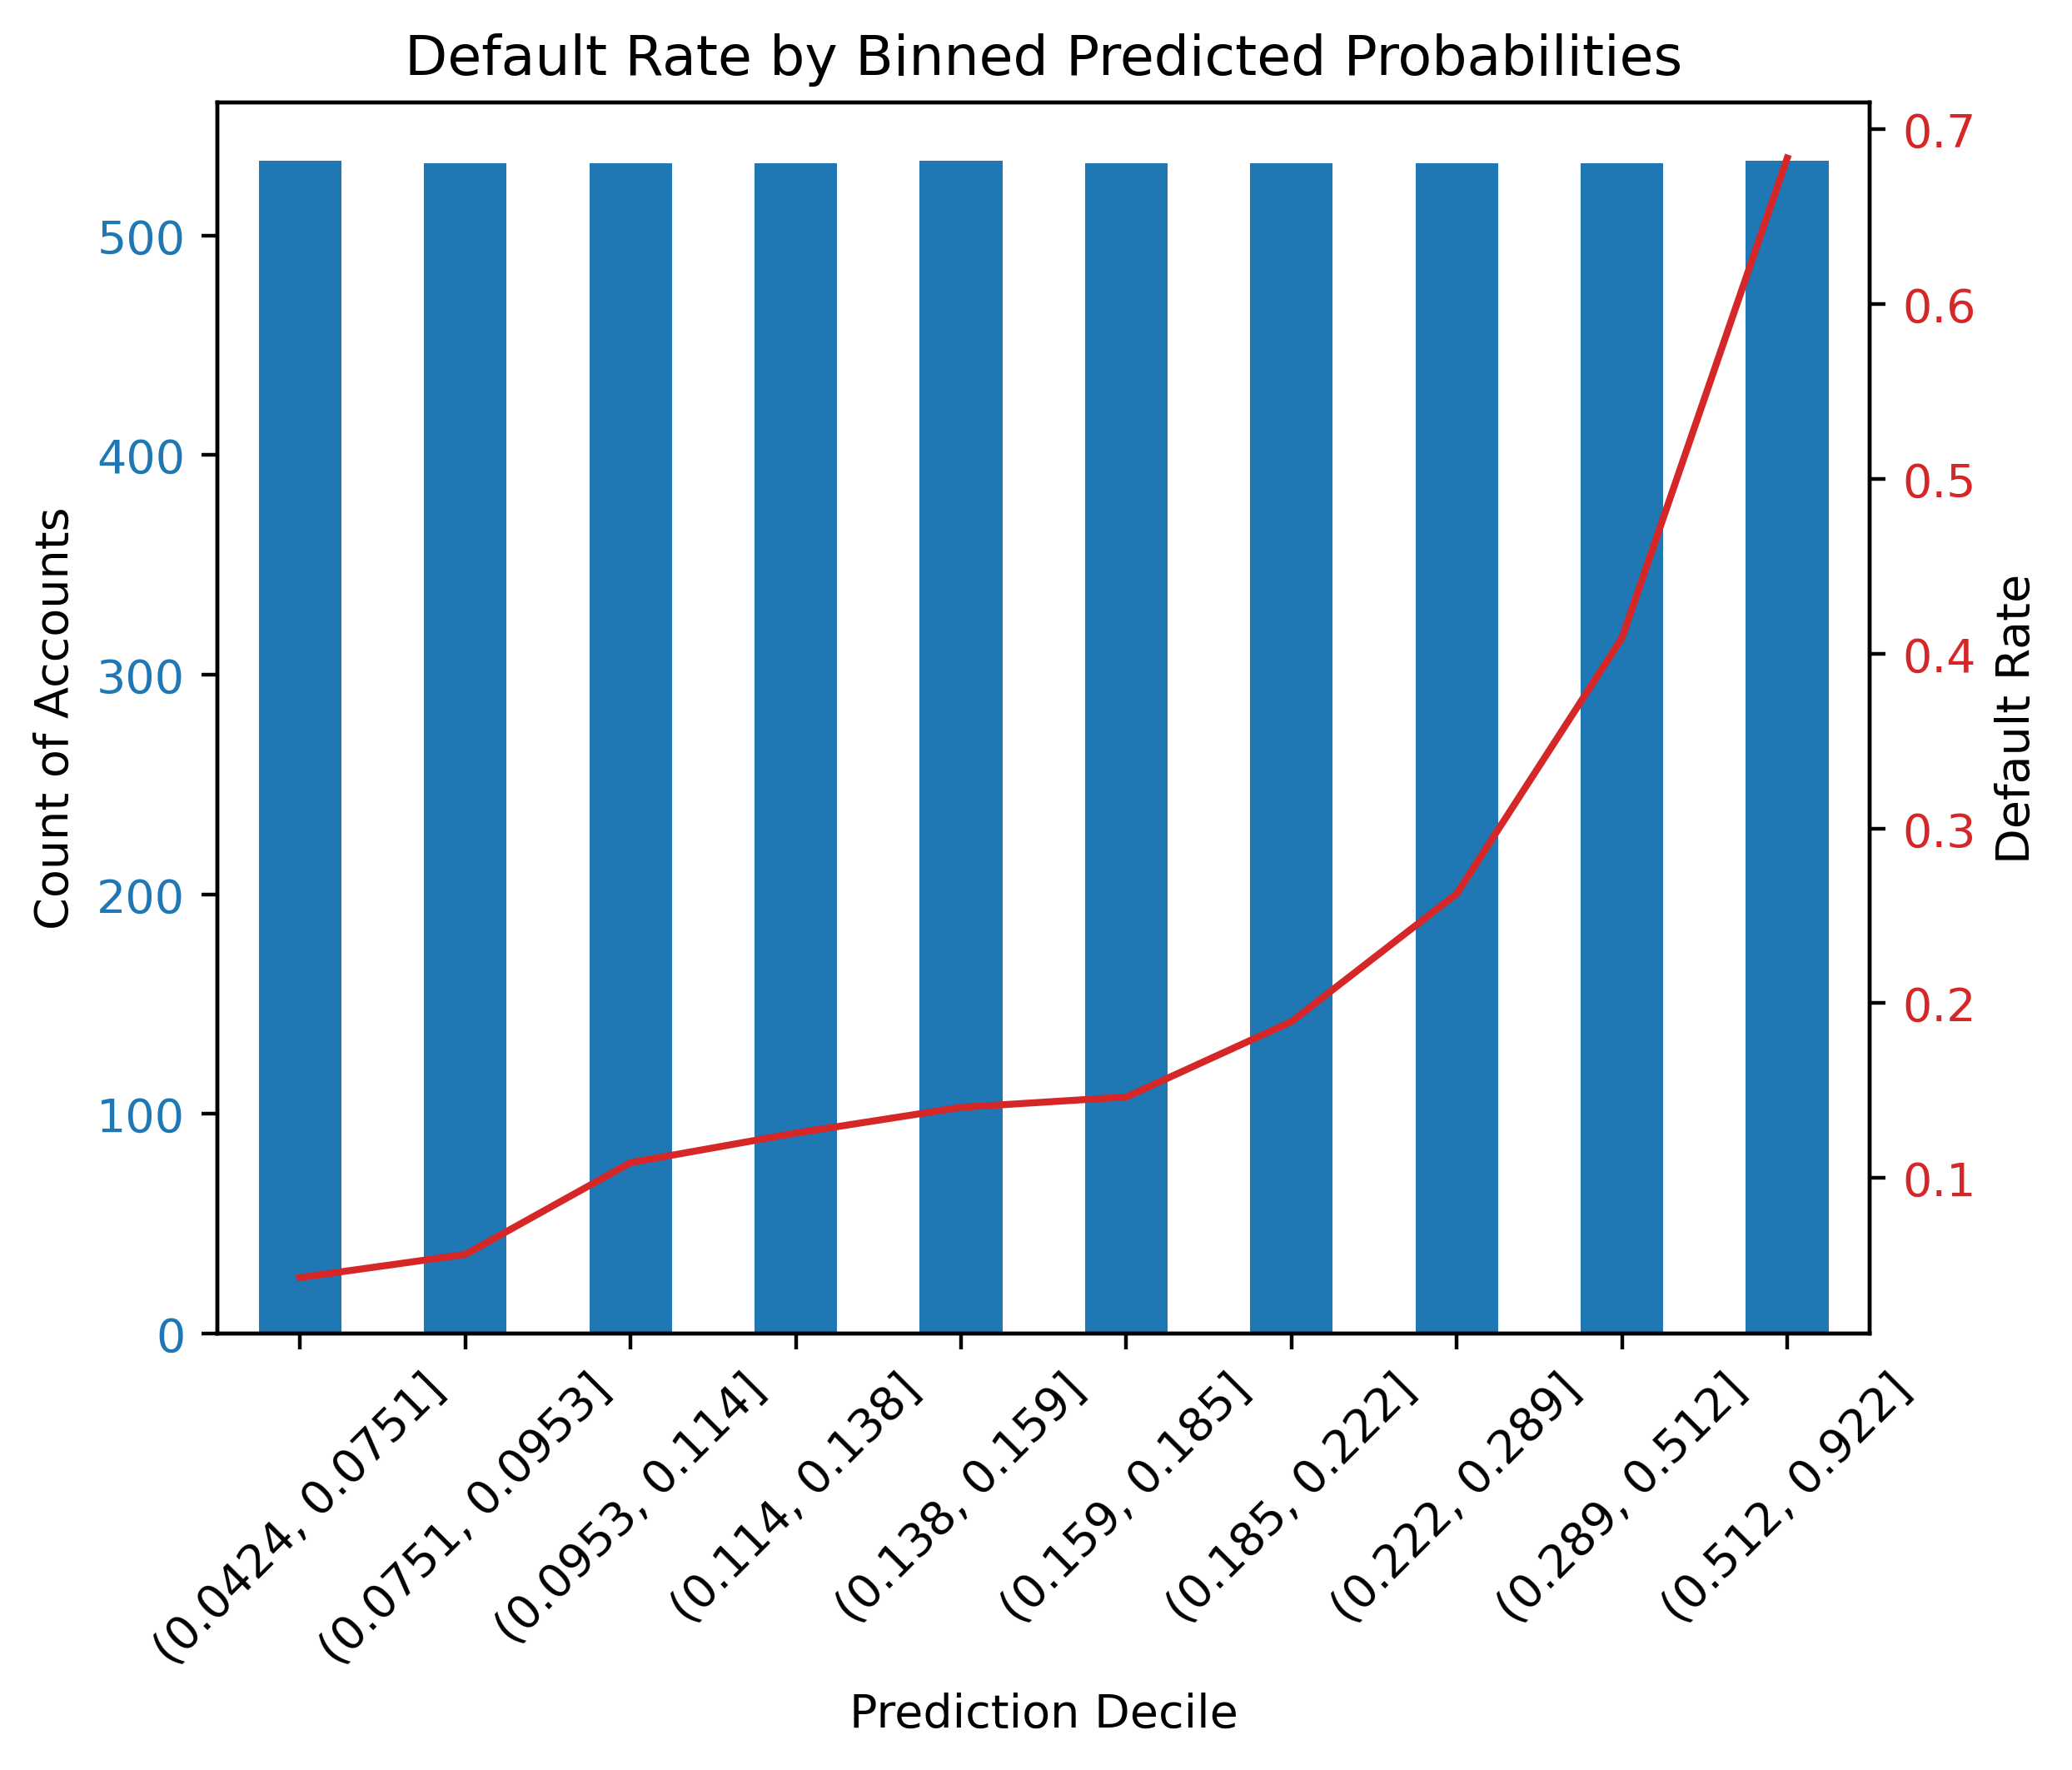

In [98]:
ax_1 = plt.axes()  # Primary y-axis
color_1 = 'tab:blue'
test_set_gr[('True Classification', 'count')].plot.bar(color=color_1, ax=ax_1)
ax_1.set_ylabel('Count of Accounts')
ax_1.set_title('Default Rate by Binned Predicted Probabilities')
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation=45)

ax_2 = ax_1.twinx()  # Secondary y-axis
color_2 = 'tab:red'
test_set_gr[('True Classification', 'mean')].plot(color=color_2, ax=ax_2)
ax_2.set_ylabel('Default Rate')
ax_2.tick_params(axis='y', labelcolor=color_2)

# As binned decile probability increases, rate of default increases. This demonstrates that our model is classifying as intended.
# Sloping the population being examined - Distinguishing groups of borrowers with consistently increasing default risk 

In [99]:
# Examining default rates by evenly binned ranges of probability of default
even_bins, even_bin_edges = pd.cut(x=test_set_pred_proba, bins=5, retbins=True)


In [100]:
test_set_df_2 = pd.DataFrame(
    {
        'Predicted Probability': test_set_pred_proba,
        'Probability Bin': even_bins,
        'True Classification': y_test
    }
)

test_set_df_2_gr = test_set_df_2.groupby(by='Probability Bin').agg({'True Classification': ['count', 'mean']})
test_set_df_2_gr

True Classification          
                              count      mean
Probability Bin                              
(0.0425, 0.219]                3689  0.115478
(0.219, 0.395]                  918  0.307190
(0.395, 0.571]                  241  0.439834
(0.571, 0.746]                  399  0.676692
(0.746, 0.922]                   86  0.825581

In [105]:
# Because we are now observing evenly split bin probability ranges, there will be lower observed samples for higher probability bins. This may result in less robust estimates of the default rate for some binned ranges as compared to others
# To account for this, find standard error 
# Standard error of mean of sample = standard deviation of sample / square root of sample size
# For binary classifications, standard error of mean for the binned ranges can be represented as square root of p(1-p) / n where 'p' represents the probability of positive classfication

p = test_set_df_2_gr[('True Classification', 'mean')]
n = test_set_df_2_gr[('True Classification', 'count')]
ste = np.sqrt((p * (1 - p)) / n)

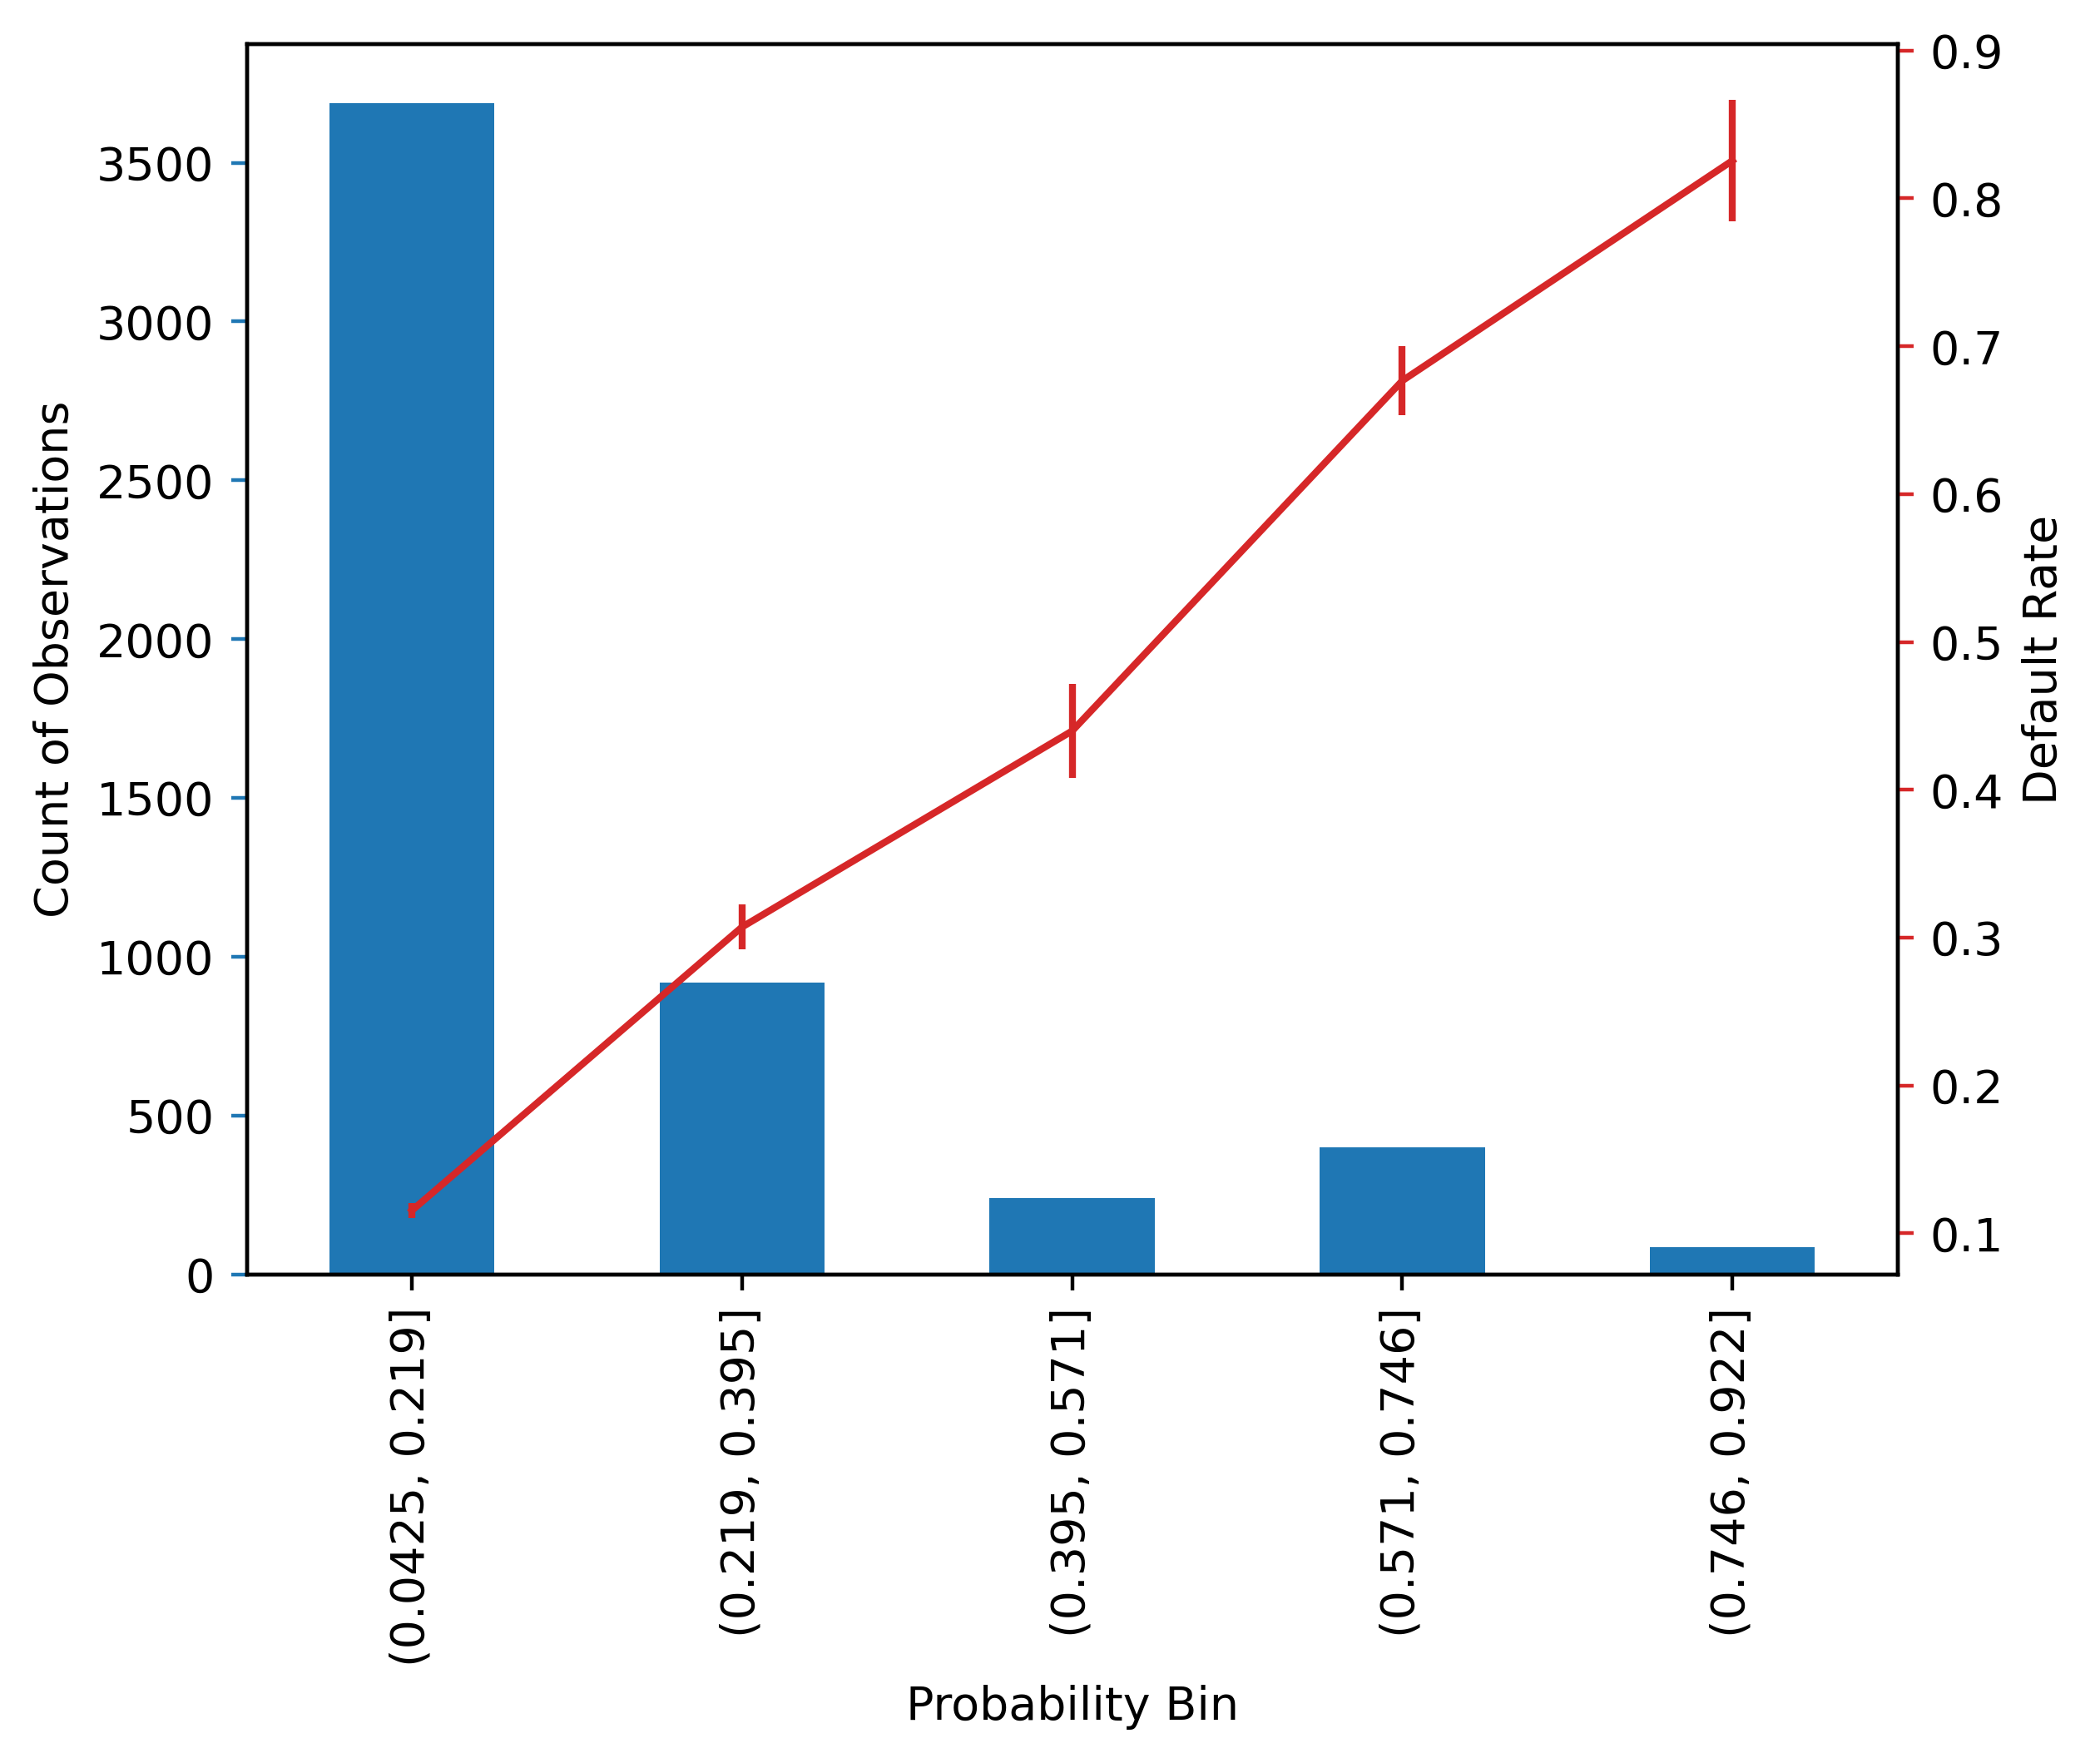

In [107]:
ax_1 = plt.axes()
color_1 = 'tab:blue'
test_set_df_2_gr[('True Classification', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of Observations')
ax_1.tick_params(axis='y', color=color_1)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
test_set_df_2_gr[('True Classification', 'mean')].plot(ax=ax_2, color=color_2, yerr=ste)
ax_2.set_ylabel('Default Rate')
ax_2.tick_params(axis='y', color=color_2)

# STE increases with lower sample sizes, as expected by standard error formula
# STE is relatively small compared to the increasing trend of default rates with each increasing probability bin

In [123]:
test_set_df

,Predicted Probability,Prediction Decile,True Classification
0,0.497302,"(0.289, 0.512]",0
1,0.500612,"(0.289, 0.512]",0
2,0.074891,"(0.0424, 0.0751]",0
3,0.890613,"(0.512, 0.922]",1
4,0.268906,"(0.222, 0.289]",0
...,...,...,...
5328,0.128240,"(0.114, 0.138]",0
5329,0.149154,"(0.138, 0.159]",0
5330,0.100040,"(0.0953, 0.114]",0
5331,0.381621,"(0.289, 0.512]",0


In [126]:
test_set_df.columns

Index(['Predicted  Probability', 'Prediction Decile', 'True Classification'], dtype='object')

In [130]:
# Looking at Expected Calibration Error (ECE)
ece_test_set_gr = test_set_df.groupby(by='Prediction Decile').agg({'True Classification': ['count', 'mean'], 'Predicted Probability': 'mean'})  # Using index Prediction Decile, get average of predicted probabilities within bin as part of ECE formula
ece_test_set_gr


True Classification           Predicted  Probability
                                count      mean                   mean
Prediction Decile                                                     
(0.0424, 0.0751]                  534  0.043071               0.063955
(0.0751, 0.0953]                  533  0.056285               0.084712
(0.0953, 0.114]                   533  0.108818               0.104316
(0.114, 0.138]                    533  0.125704               0.125818
(0.138, 0.159]                    534  0.140449               0.149117
(0.159, 0.185]                    533  0.146341               0.171931
(0.185, 0.222]                    533  0.189493               0.202641
(0.222, 0.289]                    533  0.262664               0.249256
(0.289, 0.512]                    533  0.409006               0.372608
(0.512, 0.922]                    534  0.683521               0.681646

In [137]:
# Defining proportion of samples that fall within a bin as F according to ECE formula
F = ece_test_set_gr[('True Classification', 'count')].values / X_test.shape[0]
F
# Ece formula also has proportion of samples in bin that are positive classifications. This is the same as the default rate in our case study

array([0.10013126, 0.09994375, 0.09994375, 0.09994375, 0.10013126,
       0.09994375, 0.09994375, 0.09994375, 0.09994375, 0.10013126])

In [140]:
ece_test_set_gr.columns

MultiIndex([(   'True Classification', 'count'),
            (   'True Classification',  'mean'),
            ('Predicted  Probability',  'mean')],
           )

In [146]:
ece = np.sum(F * np.abs(ece_test_set_gr[('True Classification', 'mean')].values - ece_test_set_gr[('Predicted Probability', 'mean')].values))

In [147]:
ece
# ECE as a standalone value does not show much. However, plotted over time after the model has been put into production, ECE values can be monitored. If ECE increases, this is a sign the model is becoming less calibrated and may need retraining.

0.015298489497402555

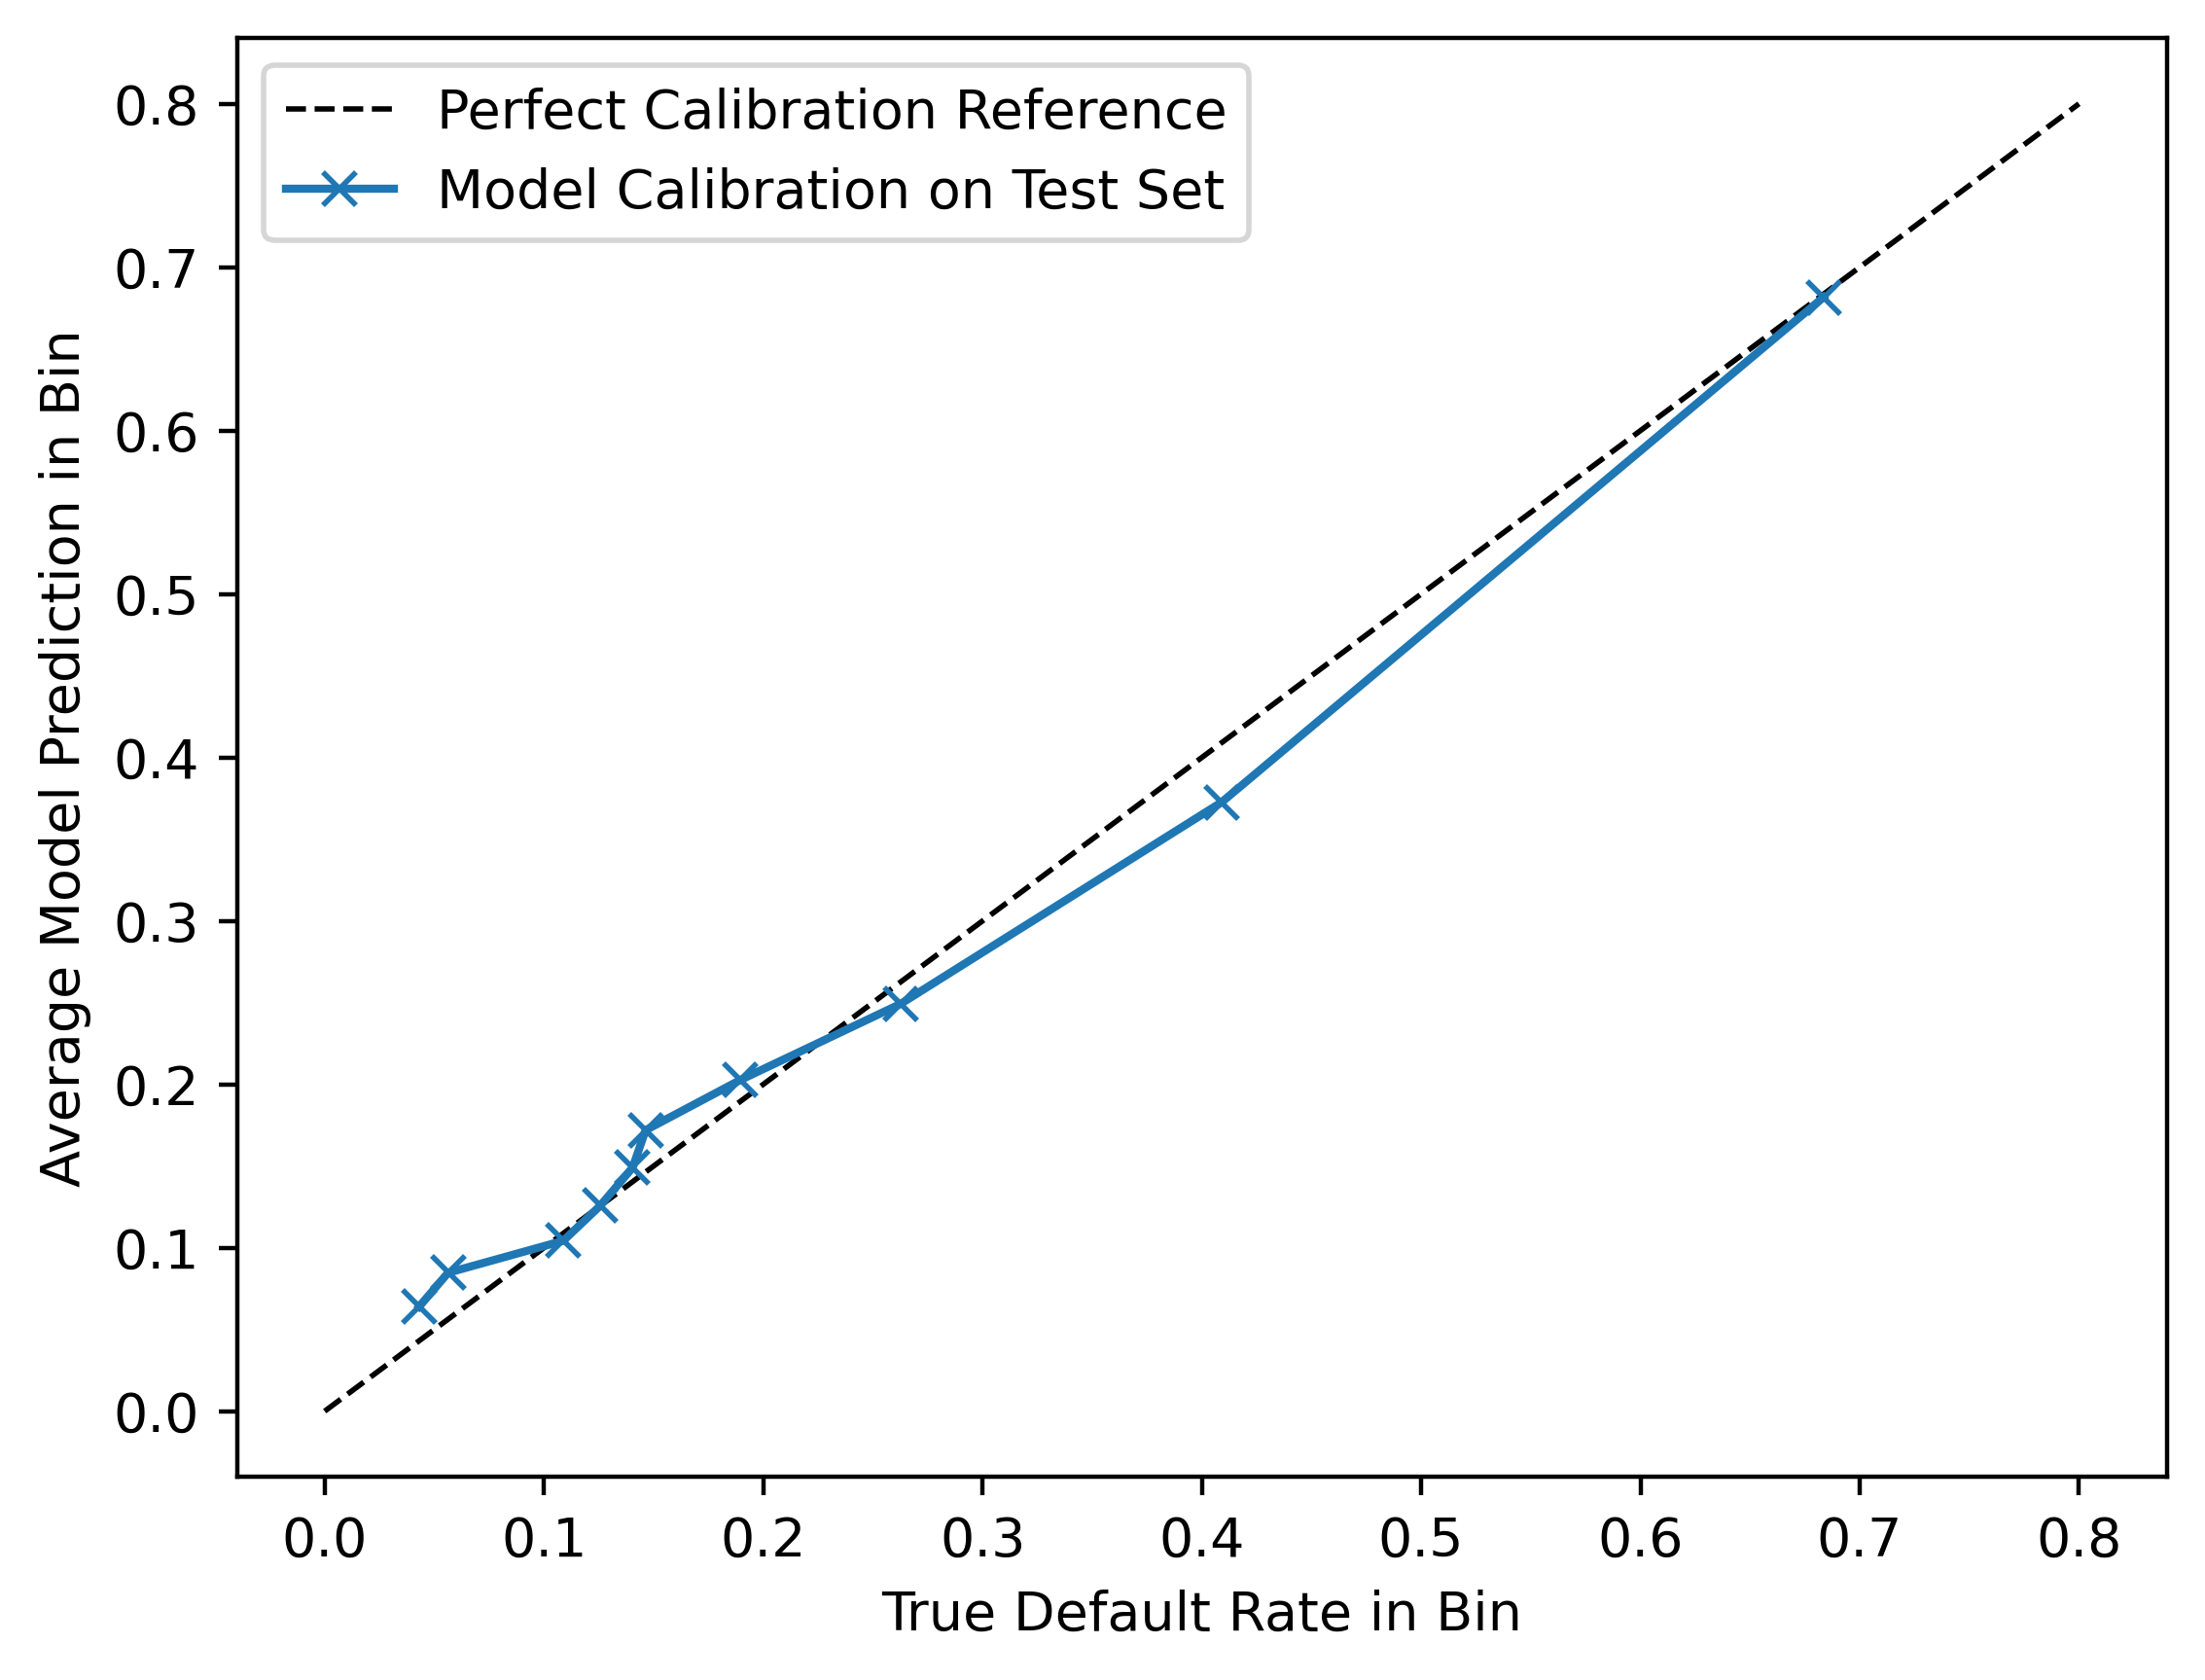

In [153]:
ax = plt.axes()
ax.plot([0, 0.8], [0, 0.8], 'k--', linewidth=1, label='Perfect Calibration Reference')
ax.plot(ece_test_set_gr[('True Classification', 'mean')].values, ece_test_set_gr[('Predicted  Probability', 'mean')].values, 'x-', label='Model Calibration on Test Set')
ax.set_xlabel('True Default Rate in Bin')
ax.set_ylabel('Average Model Prediction in Bin')
ax.legend()